In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os
import datetime

import urllib
import requests
import io
import json
import pylab as pl
import shapely
import shapely.wkt
from fiona.crs import from_epsg
import sys
from choropleth import choroplethNYC as cp
from censusapi import myapi
from carto import get_data
from featureplot import featureImportancePlot

import statsmodels as sm
import statsmodels.formula.api as smf
import scipy as sp
from scipy import stats
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#for modeling
import sklearn.preprocessing as preprocessing
from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.ensemble  import RandomForestRegressor as rfr
from sklearn.ensemble  import GradientBoostingClassifier as gdb
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Setting random seed for reproducibility 
random.seed(12345)

# PART 1: Collecting Data

**Reading in SAT 2012 data**

- Data is from NYC Open Data Portal: https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4
- Once on page, select 'Export' and then 'CSV' 

In [3]:
sat = pd.read_csv('https://data.cityofnewyork.us/api/views/f9bf-2cp4/rows.csv?accessType=DOWNLOAD')

In [4]:
sat.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


In [5]:
sat.shape

(478, 6)

In [6]:
# There is an 's' in each of the columns, converting them to NaN
sat['SAT Writing Avg. Score'].replace('s', np.nan, inplace=True)

In [7]:
sat['SAT Math Avg. Score'].replace('s', np.nan, inplace=True)

In [8]:
sat['SAT Critical Reading Avg. Score'].replace('s', np.nan, inplace=True)

In [9]:
# I am dropping NaNs
satD = sat.dropna(axis=1, how='all')

In [10]:
satD.shape # NaNs were not dropped, but this doesn't seem to be a problem later

(478, 6)

In [11]:
# Converting columns to float so I can take the mean

In [12]:
satD['SAT Critical Reading Avg. Score'] = satD['SAT Critical Reading Avg. Score'].astype(float)

In [13]:
satD['SAT Math Avg. Score'] = satD['SAT Math Avg. Score'].astype(float)

In [14]:
satD['SAT Writing Avg. Score'] = satD['SAT Writing Avg. Score'].astype(float)

In [15]:
# from stack overflow: col = df.loc[: , "salary_1":"salary_3"]
# df['salary_mean'] = col.mean(axis=1)
# https://stackoverflow.com/questions/48366506/calculate-new-column-as-the-mean-of-other-columns-pandas

cols = satD.loc[:, 'SAT Critical Reading Avg. Score':'SAT Writing Avg. Score']
satD['satall'] = cols.mean(axis=1)
satD.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,satall
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,374.000000
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,390.666667
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,383.000000
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,391.333333
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,402.333333


In [16]:
satF = satD[['DBN', 'SAT Math Avg. Score', 'satall']]
satF.rename(columns={'SAT Math Avg. Score':'satmath'}, inplace=True)
satF.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,DBN,satmath,satall
0,01M292,404.0,374.000000
1,01M448,423.0,390.666667
2,01M450,402.0,383.000000
3,01M458,401.0,391.333333
4,01M509,433.0,402.333333


In [17]:
satF.shape

(478, 3)

In [18]:
satF.to_csv("satScoresNYC.csv", index=False)

**Crime Data**

- Data is from NYC Open Data Portal: https://data.cityofnewyork.us/Education/2010-2016-School-Safety-Report/qybk-bjjc
- Once on page, select 'Export' and then 'CSV'

In [19]:
scrime = pd.read_csv('https://data.cityofnewyork.us/api/views/qybk-bjjc/rows.csv?accessType=DOWNLOAD')

In [20]:
scrime.head()

,School Year,Building Code,DBN,Location Name,Location Code,Address,Borough,Geographical District Code,Register,Building Name,...,Borough Name,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,2013-14,K001,15K001,P.S. 001 The Bergen,K001,309 47 STREET,K,15.0,"1,277",NaN,...,BROOKLYN,11220.0,40.649042,-74.012289,7.0,38.0,80.0,3011821.0,3.007550e+09,Sunset Park West ...
1,2013-14,K002,17K002,Parkside Preparatory Academy,K002,655 PARKSIDE AVENUE,K,17.0,479,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
2,2013-14,K002,75K141,P.S. K141,K141,655 PARKSIDE AVENUE,K,17.0,397,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
3,2013-14,K002,84K704,Explore Charter School,K704,655 PARKSIDE AVENUE,K,17.0,NaN,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
4,2013-14,K002,NaN,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,NaN,655 PARKSIDE AVENUE,K,17.0,876,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...


In [21]:
scrime.ENGroupA.unique()

array(['7C', '3C', nan, '5C', '4C', '6C', '2C', '8C', '9C', '12C', '10C',
       '11C', '13C'], dtype=object)

In [22]:
scrime.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,Geographical District Code,# Schools,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL
count,6304.000000,6310.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3553.000000,3553.000000,3553.00000,3553.000000,3553.000000,6286.000000,6286.000000,6286.000000,6286.000000,6286.000000,6286.000000,6.274000e+03,6.274000e+03
mean,15.321383,2.277179,0.500140,1.947767,3.305813,1.258635,0.893008,0.500808,1.939792,3.28456,1.256738,0.888413,10788.239262,40.736621,-73.920193,7.305918,24.414731,6919.579224,2.728418e+06,2.660526e+09
std,9.175539,1.604115,1.019783,3.152415,6.801891,2.065283,1.759583,0.417370,1.762414,4.08533,1.066777,0.805513,528.641970,0.085322,0.077559,4.558376,14.525832,21769.657280,1.178422e+06,1.137461e+09
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.240000,0.710000,1.09000,0.510000,0.320000,10001.000000,40.508284,-74.244118,1.000000,1.000000,1.000000,1.000003e+06,1.000020e+09
25%,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,32.000000,11.000000,15.000000,29.000000,84.000000,22.000000,20.000000,3.330000,13.000000,34.86000,9.200000,7.170000,11694.000000,40.903553,-73.707418,18.000000,51.000000,157903.000000,5.149609e+06,5.078980e+09


In [23]:
scrime.shape

(6310, 34)

**Inspecting distribution of crimes per school**
- I chose to look at major crimes, grouping by Building Code. Originally, I planned to group by DBN. Since I discovered there are many NaNs for DBN, I decided to use Building Code instead.

In [24]:
# grouping major crimes by building code
scrimeBC = scrime[['Building Code', 'Major N']].groupby(by='Major N').count()
scrimeR = scrimeBC.reset_index()
scrimeR.head()

,Major N,Building Code
0,0.0,2519
1,1.0,633
2,2.0,231
3,3.0,100
4,4.0,44


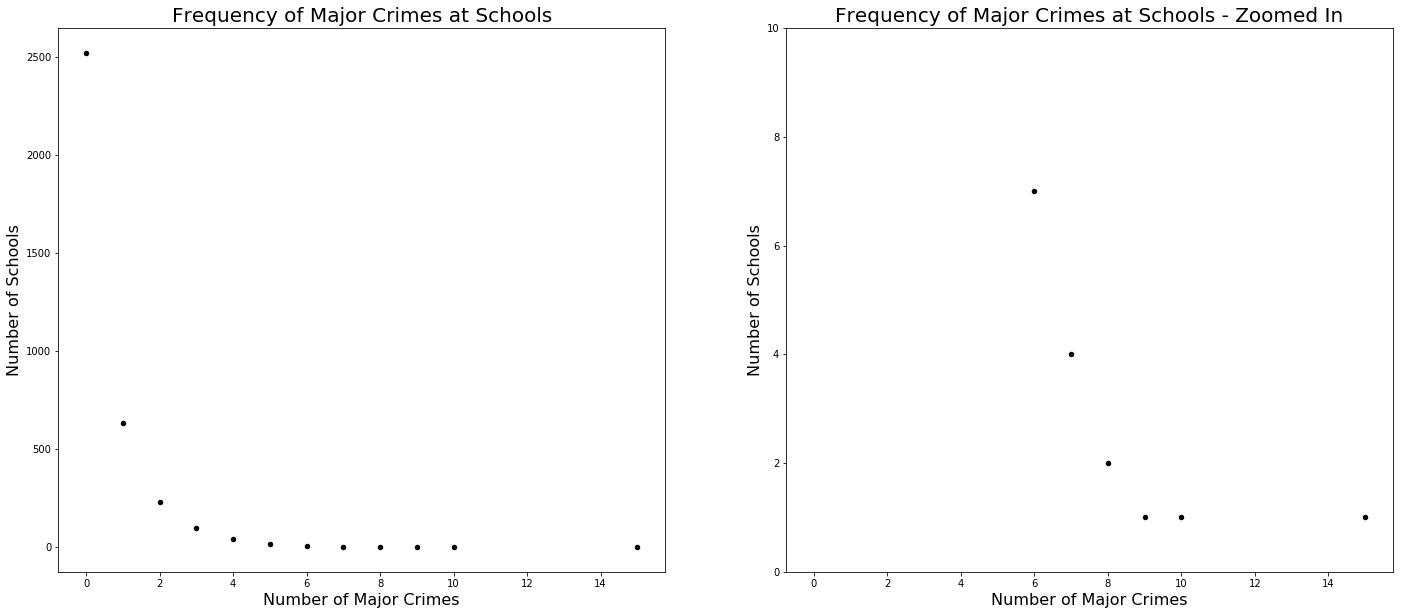

In [25]:
fig = pl.figure(figsize=(50,10))

ax1 = fig.add_subplot(141)
ax1.set_title('Frequency of Major Crimes at Schools', fontsize=20)
figure = scrimeR.plot(x='Major N', y='Building Code', kind='scatter', color='black', ax=ax1)
pl.xlabel('Number of Major Crimes', fontsize=16)
pl.ylabel('Number of Schools', fontsize=16)
pl.legend()

ax2 = fig.add_subplot(142)
ax2.set_title('Frequency of Major Crimes at Schools - Zoomed In', fontsize=20)
figure = scrimeR.plot(x='Major N', y='Building Code', kind='scatter', color='black', ax=ax2)
pl.xlabel('Number of Major Crimes', fontsize=16)
pl.ylabel('Number of Schools', fontsize=16)
ax2.set_ylim(0, 10)
pl.legend()

Figure 1: Numbner of major crimes per building code in NYC schools from 2010-2016. Data was retrieved from NYC Open Data Portal. Data were grouped by building code, and multiple schools can share the same building code. The vast majority of schools have had zero major crimes, as shown in the figure on the left. Because of the scale, it is hard to see the small number of schools that have had more than a few major incidents. Examining the zoomed in figure on the right, we can more clearly see the number of schools that have had a higher number of major crimes.  

**Plot the distribution of "Average number of Major" crimes by school**

In [26]:
# grouping average major crimes by building code
scrimeAvgM = scrime[['Building Code', 'AvgOfMajor N']].groupby(by='AvgOfMajor N').count()
scrimeAvgM = scrimeAvgM.reset_index()
scrimeAvgM.head()

,AvgOfMajor N,Building Code
0,0.24,72
1,0.27,488
2,0.28,325
3,0.31,328
4,0.33,333


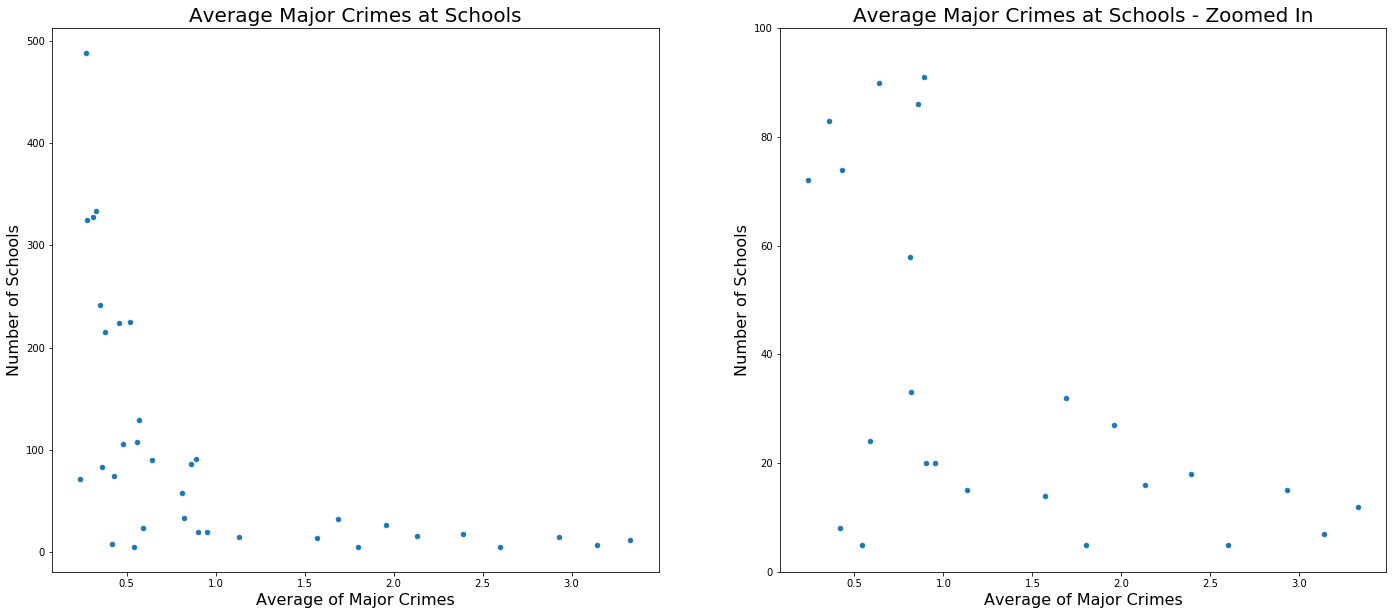

In [27]:
fig = pl.figure(figsize=(50,10))

ax1 = fig.add_subplot(141)
ax1.set_title('Average Major Crimes at Schools', fontsize=20)
figure = scrimeAvgM.plot(x='AvgOfMajor N', y='Building Code', kind='scatter', ax=ax1)
pl.xlabel('Average of Major Crimes', fontsize=16)
pl.ylabel('Number of Schools', fontsize=16)
pl.legend()

ax2 = fig.add_subplot(142)
ax2.set_title('Average Major Crimes at Schools - Zoomed In', fontsize=20)
figure = scrimeAvgM.plot(x='AvgOfMajor N', y='Building Code', kind='scatter', ax=ax2)
pl.xlabel('Average of Major Crimes', fontsize=16)
pl.ylabel('Number of Schools', fontsize=16)
ax2.set_ylim(0, 100)
pl.legend()

Figure 2: Average major crimes in NYC schools from 2010-2016. Data was retrieved from NYC Open Data Portal. Data were again grouped by building code. Average of major crimes differs from major crimes in that the former is an average for all buildings that have the same group name and building population. An example of this would be Parkside Preparatory Academy and P.S. K141, two schools in Brooklyn. This graphic is similar in structure to the first plot - the vast majority of schools grouped in this manner have a low major crime rate. It is noteable that there an average of 0 major crimes does not appear in these plots. 

# Part 2: Merging school crime and SAT data

**2.1 Merge the SAT and the crime in school data based on the school identifier**

In [28]:
# reading back in cleaned SAT data
scores = pd.read_csv('satScoresNYC.csv')

In [29]:
# merging scores with crime data
schoolSAT = scrime.merge(scores, on='DBN')
schoolSAT.head()

,School Year,Building Code,DBN,Location Name,Location Code,Address,Borough,Geographical District Code,Register,Building Name,...,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,satmath,satall
0,2013-14,K026,16K393,Frederick Douglass Academy IV Secondary School,K393,1014 LAFAYETTE AVENUE,K,16.0,155,1014 LAFAYETTE AVENUE CONSOLIDATED LOCATION,...,40.692126,-73.931731,3.0,36.0,291.0,3393805.0,3.016160e+09,Stuyvesant Heights ...,355.0,356.0
1,2014-15,K026,16K393,Frederick Douglass Academy IV Secondary School,K393,1014 LAFAYETTE AVENUE,K,16.0,92,1014 LAFAYETTE AVENUE CONSOLIDATED LOCATION,...,40.692126,-73.931731,3.0,36.0,291.0,3393805.0,3.016160e+09,Stuyvesant Heights ...,355.0,356.0
2,2015-16,K026,16K393,Frederick Douglass Academy IV Secondary School,K393,1014 LAFAYETTE AVENUE,K,16.0,77,1014 LAFAYETTE AVENUE CONSOLIDATED LOCATION,...,40.692126,-73.931731,3.0,36.0,291.0,3393805.0,3.016160e+09,Stuyvesant Heights ...,355.0,356.0
3,2013-14,M824,02M418,Millennium High School,M418,75 BROAD STREET,M,2.0,619,NaN,...,40.704487,-74.011556,1.0,1.0,9.0,1000849.0,1.000290e+09,Battery Park City-Lower Manhattan ...,553.0,538.0
4,2014-15,M824,02M418,Millennium High School,M418,75 BROAD STREET,M,2.0,659,NaN,...,40.704487,-74.011556,1.0,1.0,9.0,1000849.0,1.000290e+09,Battery Park City-Lower Manhattan ...,553.0,538.0


In [30]:
schoolSAT.shape

(1359, 36)

** After merging, we have 1359 datapoints. We started off with 6310 from the crime dataset and 478 from the SAT dataset.**

In [31]:
schoolSAT.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,Geographical District Code,# Schools,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,...,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,satmath,satall
count,1359.000000,1359.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,...,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1.348000e+03,1.348000e+03,1202.000000,1202.000000
mean,13.718175,3.288447,0.825065,3.616188,5.535248,2.300261,1.493473,0.650366,2.710940,4.686867,...,10711.896373,40.742543,-73.926089,6.857883,21.946706,4515.423390,2.555216e+06,2.485362e+09,415.435108,404.233222
std,9.287388,2.158132,1.394904,4.249601,7.079443,2.950051,2.192165,0.611113,2.806753,5.711933,...,537.555588,0.081827,0.074026,4.466228,14.749317,16926.232688,1.206453e+06,1.155131e+09,65.442537,59.026226
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.240000,0.710000,1.090000,...,10001.000000,40.508809,-74.222403,1.000000,1.000000,1.000000,1.000003e+06,1.000020e+09,312.000000,295.666667
25%,6.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,12.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,21.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,32.000000,11.000000,10.000000,26.000000,51.000000,21.000000,12.000000,3.330000,13.000000,34.860000,...,11694.000000,40.888338,-73.727535,18.000000,51.000000,152902.000000,5.149609e+06,5.076640e+09,735.000000,698.666667


**2.2 Fill in the missing data as appropriate keeping in mind that the school with no crimes are not included i the crime-in-school database, so there you can assume that there were 0 crimes, but the missing SAT scores cannot be assumed to be 0 of course.**

In [32]:
# there are NaNs, so filling with 0
schoolSAT2 = schoolSAT.fillna(0)

In [33]:
# dropping SATmath with 0 or satall with 0, since a school cannot have a 0 average 0 score
schoolSAT3 = schoolSAT2[(schoolSAT2.satmath > 0 ) & (schoolSAT2.satall > 0 ) ]

In [34]:
schoolSAT3.shape

(1202, 36)

In [35]:
# dropping SATmath with 0 or satall with 0
schoolSAT4 = schoolSAT3[(schoolSAT3.Postcode > 0 ) & (schoolSAT3.Latitude > 0 ) ]

In [36]:
schoolSAT4.shape

(1197, 36)

**Lost about 160 values since the original merge**

**2.3 Count the individual school location: there may be multiple schools in a single building. What could be the implication of this in your analysis?**

In [37]:
# combine lat and lon to one column
schoolSAT4['lonlat']=list(zip(schoolSAT4.Longitude, schoolSAT4.Latitude))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [38]:
school5 = schoolSAT4.groupby(['lonlat', 'Location Code']).mean().reset_index()

In [39]:
schools6 = schoolSAT4.merge(school5, on='lonlat')

In [40]:
schools7 = schools6.groupby(['lonlat', 'DBN']).mean().reset_index()

In [41]:
schools = schools7[['DBN', 'Major N_x', 'Oth N_x', 'NoCrim N_x', 'Prop N_x', 'Vio N_x',
       'AvgOfMajor N_x', 'AvgOfOth N_x', 'AvgOfNoCrim N_x', 'AvgOfProp N_x',
       'AvgOfVio N_x', 'satmath_x', 'satall_x', 'Latitude_x', 'Longitude_x']]
schools.columns = schools.columns.str.replace('_x', '')
#schools.columns = schools.columns.str.replace(' ', '_')
schools.head()

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,satmath,satall,Latitude,Longitude
0,31R455,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,486.0,472.666667,40.528092,-74.192032
1,31R607,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,375.0,383.333333,40.528092,-74.192032
2,31R047,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,451.0,451.000000,40.581315,-74.158589
3,31R064,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,412.0,398.333333,40.581315,-74.158589
4,31R445,1.333333,14.333333,26.333333,7.0,6.333333,0.756667,3.806667,6.61,2.25,1.846667,438.0,426.333333,40.634573,-74.141818


In [42]:
schools.rename(columns={'satmath':'SATmath', 'satall':'SATall'}, inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [43]:
schools.describe()

,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,Latitude,Longitude
count,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000
mean,0.228964,1.061084,1.619337,0.678398,0.417476,0.192132,0.808758,1.404312,0.521861,0.340008,414.524272,403.486246,40.742510,-73.924298
std,0.678047,2.650214,4.331647,1.717689,1.186997,0.430928,1.958908,3.745982,1.233138,0.794532,64.889402,58.469939,0.082202,0.072782
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,312.000000,295.666667,40.528092,-74.192032
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.000000,367.583333,40.685004,-73.979292
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,396.000000,390.166667,40.738343,-73.927110
75%,0.000000,0.333333,0.333333,0.333333,0.000000,0.296667,0.928333,1.370000,0.717500,0.407500,438.000000,420.750000,40.818250,-73.888267
max,7.333333,19.666667,38.666667,14.333333,8.333333,3.133333,12.443333,33.630000,7.060000,5.863333,735.000000,698.666667,40.888338,-73.727535


**RESULTS OF DATA WRANGLING** In the end, I have about 400 observations. From the hints, I planned to groupby Latitude and Longitude. Just grouping by these features did not generate the dataset I was looking for. So, I created a lat/lon column, grouped by that parameter and location code, since grouping along by lat/lon did not yield good results. I took the mean of all these grouped values. I then put that back into the original dataset, and grouped again - this time by DBN, and took the mean. In the end, I have about 400 observations. Comparing my dataframe to Dr. Bianco's, our mean and standard deviation values are not wildly different. Further, I completed most of the analysis with her initial solution, and then went back to see if I could figure this part out. After running all of my subsequent code with the 400 observation dataframe, I get similar maps, figures, and analysis as when I used Dr. Bianco's solution. 

**Implication of multiple schools being in the same building** The implication is that we are examining crime by building (or collection of buildings) not per person. The same number of crimes at a building with 250 students and a school with 1,000 students will be weighted the same. There may be some validity to looking at building level crime, but a per person measure would be a more accurate way of reflecting crime incidence. 

# Part 3 Visualize the school related data


**3.1 plot the Math SAT score and the average of all SAT scores (the feature you created in Task 1) as a function of two crime statistics**

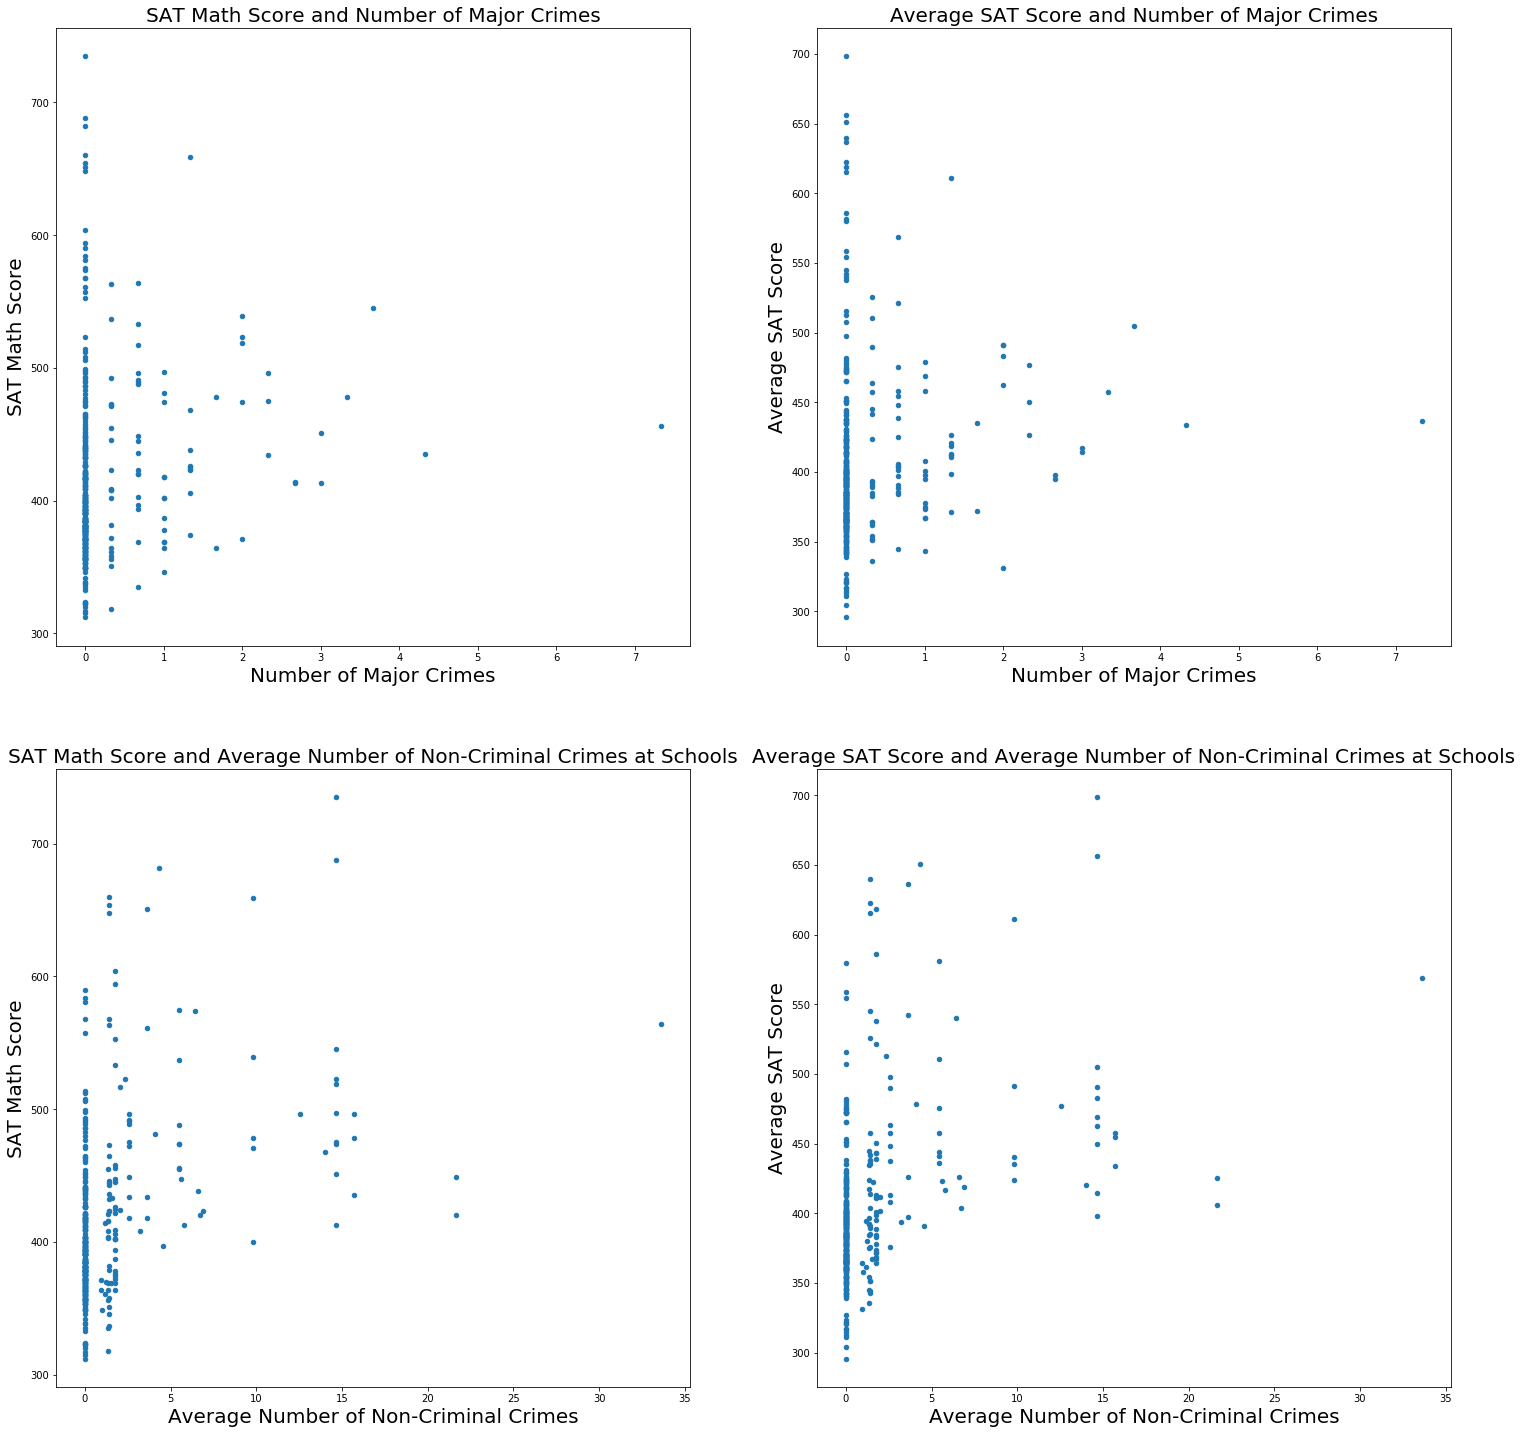

In [44]:
fig = pl.figure(figsize=(25,25))

ax1 = fig.add_subplot(221)
ax1.set_title('SAT Math Score and Number of Major Crimes', fontsize=20)
figure = schools.plot(x='Major N', y='SATmath', kind='scatter', ax=ax1)
pl.xlabel('Number of Major Crimes', fontsize=20)
pl.ylabel('SAT Math Score', fontsize=20)
pl.legend()

ax2 = fig.add_subplot(222)
ax2.set_title('Average SAT Score and Number of Major Crimes', fontsize=20)
figure = schools.plot(x='Major N', y='SATall', kind='scatter', ax=ax2)
pl.xlabel('Number of Major Crimes', fontsize=20)
pl.ylabel('Average SAT Score', fontsize=20)
pl.legend()

ax3 = fig.add_subplot(223)
ax3.set_title('SAT Math Score and Average Number of Non-Criminal Crimes at Schools', fontsize=20)
figure = schools.plot(x='AvgOfNoCrim N', y='SATmath', kind='scatter', ax=ax3)
pl.xlabel('Average Number of Non-Criminal Crimes', fontsize=20)
pl.ylabel('SAT Math Score', fontsize=20)
pl.legend()


ax4 = fig.add_subplot(224)
ax4.set_title('Average SAT Score and Average Number of Non-Criminal Crimes at Schools', fontsize=20)
figure = schools.plot(x='AvgOfNoCrim N', y='SATall', kind='scatter', ax=ax4)
pl.xlabel('Average Number of Non-Criminal Crimes', fontsize=20)
pl.ylabel('Average SAT Score', fontsize=20)
pl.legend()



Figure 3: In the first row, we've plotted the two SAT features against major crime. Both plots look to be forming a bell-shaped distribution. Since they are different measures but producing extremely similar results, this leads me to believe these features are highly covariant. The relationship between SAT feature and average non-criminal crime is less clear. While not circular, the data do not produce on obvious trend. 

**3.2 Create geometry from the lat-lon coordinates and map the location of each school in the dataset**

In [45]:
schools.head()

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,Latitude,Longitude
0,31R455,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,486.0,472.666667,40.528092,-74.192032
1,31R607,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,375.0,383.333333,40.528092,-74.192032
2,31R047,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,451.0,451.000000,40.581315,-74.158589
3,31R064,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,412.0,398.333333,40.581315,-74.158589
4,31R445,1.333333,14.333333,26.333333,7.0,6.333333,0.756667,3.806667,6.61,2.25,1.846667,438.0,426.333333,40.634573,-74.141818


In [46]:
schools['Coordinates'] = list(zip(schools.Longitude, schools.Latitude))
schools['Coordinates'] = schools['Coordinates'].apply(Point)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [47]:
schoolsG = gpd.GeoDataFrame(schools, geometry='Coordinates')

In [48]:
schoolsG.crs = from_epsg(4326)
schoolsG.to_crs(epsg=2263, inplace=True)

**Getting the Boroughs shape file from NYC Open Data**

- To download shape file and move to PUIDATA, uncomment the block of code below

In [49]:
# url = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile"
# urllib.request.urlretrieve(url, "file.gz")

In [50]:
# !unzip -d $PUIDATA file.gz

In [51]:
boro = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + '/geo_export_c36fe5cf-1a08-4d91-8b50-a011a81687bd.shp')

In [52]:
boro.to_crs(epsg=2263, inplace=True)

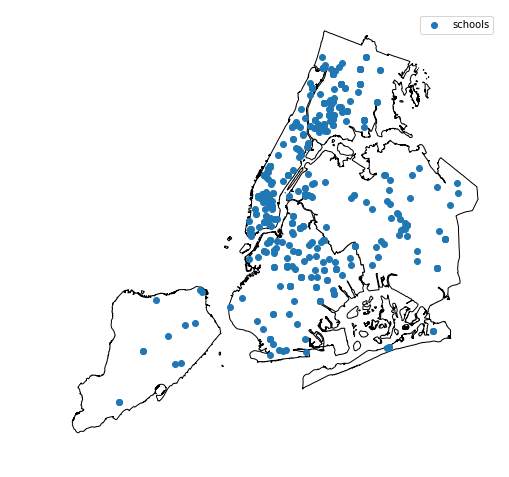

In [53]:
ax = boro.plot(facecolor="w", edgecolor="k", figsize=(8,12))
schoolsG.plot(ax=ax)
ax.axis('off')
plt.gca().legend(('schools','schools'));

Figure 4: Map of NYC schools located in 2010-2016 School Safety Report from NYC Open Data and for which 2012 SAT scores are available. There are a large amount of schools concentrated in Manhattan and Bronx, with only a small scattering of schools in the outer parts of Queens and Brooklyn. Very few schools in Staten Island. 

# 4 Gather Asthma and drugs hospital discharge

**4.1 Read in SPARCs data**

- To read in hospital data and move to PUI folder, uncomment cellblocks below

In [54]:
#!wget https://health.data.ny.gov/download/3m9u-ws8e/application%2Fzip

In [55]:
#!unzip application%2Fzip -d $PUIDATA

In [56]:
hosp = pd.read_csv(os.getenv('PUIDATA') + 
                   '/NYSDOH_HospitalInpatientDischarges_SPARCS_De-Identified_2012.csv')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [57]:
hosp.head()

,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs,Ratio of Total Costs to Total Charges
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,90301264.0,NaN,NaN,0,N,Y,"5,511.95","5,582.49",1.012798
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,90301264.0,NaN,NaN,0,N,Y,"4,783.20","5,162.82",1.079365
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,90301264.0,NaN,NaN,0,N,Y,"3,829.15","4,056.52",1.059379
3,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,0 to 17,147,F,White,Not Span/Hispanic,...,NaN,182357.0,NaN,NaN,0,N,Y,"1,108.20","1,644.75",1.484167
4,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,90301264.0,NaN,NaN,0,N,Y,"3,418.18","3,370.87",0.986161


In [58]:
hosp['Hospital County'].unique()

array(['Allegany', nan, 'Cattaraugus', 'Chautauqua', 'Erie', 'Genesee',
       'Niagara', 'Orleans', 'Wyoming', 'Chemung', 'Livingston', 'Monroe',
       'Ontario', 'Schuyler', 'Steuben', 'Wayne', 'Yates', 'Oswego',
       'Broome', 'Cayuga', 'Chenango', 'Cortland', 'Herkimer', 'Jefferson',
       'Lewis', 'Madison', 'Oneida', 'Onondaga', 'St Lawrence', 'Tompkins',
       'Albany', 'Clinton', 'Columbia', 'Delaware', 'Essex', 'Franklin',
       'Fulton', 'Montgomery', 'Otsego', 'Rensselaer', 'Saratoga',
       'Schenectady', 'Schoharie', 'Warren', 'Dutchess', 'Orange',
       'Putnam', 'Rockland', 'Sullivan', 'Ulster', 'Westchester', 'Bronx',
       'Kings', 'Manhattan', 'Richmond', 'Queens', 'Suffolk', 'Nassau'], dtype=object)

**4.1.1 Throw away data that is not NYC**
- Manhattan, Queens, Bronx, Kings and Richmond 

In [59]:
hospitalF = hosp[(hosp['Hospital County'] == 'Manhattan') + (hosp['Hospital County'] == 'Queens') +\
                 (hosp['Hospital County'] == 'Bronx') + (hosp['Hospital County'] == 'Kings') +\
                 (hosp['Hospital County'] == 'Richmond')]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


In [60]:
hospitalF['Hospital County'].unique()

array(['Bronx', 'Kings', 'Manhattan', 'Richmond', 'Queens'], dtype=object)

In [61]:
hospitalF.shape

(1199520, 38)

**Making df of counts of all diagnoses in anticipation of next task**

In [62]:
diagnoses = hospitalF[['Permanent Facility Id', 'CCS Diagnosis Description']]
diagcts = diagnoses.groupby(by='Permanent Facility Id').count().reset_index()
diagcts.head()

,Permanent Facility Id,CCS Diagnosis Description
0,1164.0,4917
1,1165.0,20956
2,1168.0,15889
3,1169.0,43650
4,1172.0,23142


In [63]:
diagcts.shape

(61, 2)

**4.2 calculate the fraction of asthma and drug related diagnoses per facility**
- First, need to filter out appropriate columns
- Using the df.columns method, I found which column lists discharge diagnoses: CCS Diagnosis Description
- 'Asthma', 'Respiratory failure; insufficiency; arrest (adult)', and  'Respiratory distress syndrome' for asthma related issue, and 'Poisoning by psychotropic agents', 'Alcohol-related disorders', and  'Substance-related disorders' for drug relates issues.

In [64]:
NYCdis = hospitalF[(hospitalF['CCS Diagnosis Description'] == 'Asthma') +\
                   (hospitalF['CCS Diagnosis Description'] == 'Respiratory failure') +\
                   (hospitalF['CCS Diagnosis Description'] == 'insufficiency') +\
                   (hospitalF['CCS Diagnosis Description'] == 'arrest (adult)') +\
                   (hospitalF['CCS Diagnosis Description'] == 'Respiratory distress syndrome') +\
                   (hospitalF['CCS Diagnosis Description'] == 'Poisoning by psychotropic agent') +\
                   (hospitalF['CCS Diagnosis Description'] == 'Alcohol-related disorders') +\
                   (hospitalF['CCS Diagnosis Description'] == 'Substance-related disorders')]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


In [65]:
NYCdis.head()

,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs,Ratio of Total Costs to Total Charges
973820,New York City,Bronx,7000001.0,1164.0,Bronx-Lebanon Hospital Center - Fulton Division,30 to 49,104,M,Black/African American,Not Span/Hispanic,...,NaN,232661.0,232661.0,NaN,0,N,N,"16,533.18","10,561.96",0.638834
973828,New York City,Bronx,7000001.0,1164.0,Bronx-Lebanon Hospital Center - Fulton Division,50 to 69,104,M,Black/African American,Not Span/Hispanic,...,NaN,232661.0,232661.0,NaN,0,N,N,"16,646.22","10,696.09",0.642554
973835,New York City,Bronx,7000001.0,1164.0,Bronx-Lebanon Hospital Center - Fulton Division,50 to 69,104,F,Other Race,Unknown,...,NaN,232661.0,232661.0,NaN,0,N,N,"14,566.72","9,499.08",0.652108
973836,New York City,Bronx,7000001.0,1164.0,Bronx-Lebanon Hospital Center - Fulton Division,30 to 49,104,M,Other Race,Unknown,...,NaN,232661.0,232661.0,NaN,0,N,N,"13,201.68","8,567.19",0.648947
973840,New York City,Bronx,7000001.0,1164.0,Bronx-Lebanon Hospital Center - Fulton Division,50 to 69,104,M,Other Race,Unknown,...,NaN,232661.0,232661.0,NaN,0,N,N,"12,637.48","8,486.26",0.671515


In [66]:
NYCdis['CCS Diagnosis Description'].unique()

array(['Alcohol-related disorders', 'Substance-related disorders',
       'Asthma', 'Respiratory distress syndrome'], dtype=object)

**Since my CCS diagnosis column only contains the four unique values in the cell above, I will only modify the dfs using those values**

In [67]:
# making df of counts of drugs
drugs = NYCdis[['Permanent Facility Id', 'CCS Diagnosis Description']]
drugsR = drugs[(drugs['CCS Diagnosis Description'] == 'Alcohol-related disorders') +\
               (drugs['CCS Diagnosis Description'] == 'Substance-related disorders')]
drugscts = drugsR.groupby(by='Permanent Facility Id').count().reset_index()
drugscts.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


,Permanent Facility Id,CCS Diagnosis Description
0,1164.0,2388
1,1165.0,1228
2,1168.0,990
3,1169.0,280
4,1172.0,548


In [68]:
drugscts.shape

(54, 2)

In [69]:
# making df for counts of asthma
asthma = NYCdis[['Permanent Facility Id', 'CCS Diagnosis Description']]
asthmaR = asthma[(asthma['CCS Diagnosis Description'] == 'Asthma') +\
               (asthma['CCS Diagnosis Description'] == 'Respiratory distress syndrome')]
asthmacts = asthmaR.groupby(by='Permanent Facility Id').count().reset_index()
asthmacts.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


,Permanent Facility Id,CCS Diagnosis Description
0,1165.0,1051
1,1168.0,494
2,1169.0,1930
3,1172.0,1699
4,1175.0,2


In [70]:
asthmacts.shape

(54, 2)

**Merging all counts dfs**

In [71]:
allDrugs = diagcts.merge(drugscts, on='Permanent Facility Id', how='outer')
allDrugs.shape

(61, 3)

In [72]:
allCounts = allDrugs.merge(asthmacts, on='Permanent Facility Id', how='outer')
allCounts.shape

(61, 4)

In [73]:
allCounts.rename(columns={'CCS Diagnosis Description_x':'discharges', 'CCS Diagnosis Description_y':'drugs',
                         'CCS Diagnosis Description':'asthma'}, inplace=True)

In [74]:
allCountsFilled = allCounts.fillna(0)

In [75]:
nd = allCountsFilled.discharges.sum()
print("number of NYC discharges:", nd)
#number of NYC discharges 1199520

nycF = len(allCountsFilled)
print("number of NYC facilities in the dataset:", nycF)
#number of NYC facilities in the dataset 61

nyca = allCountsFilled.asthma.sum()
print("number of asthma related cases in NYC:", nyca) 
#number of asthma related cases in NYC 30717

nycd = allCountsFilled.drugs.sum()
print("number of drug related cases in NYC:", nycd)
#number of drug related cases in NYC 46336



number of NYC discharges: 1199520
number of NYC facilities in the dataset: 61
number of asthma related cases in NYC: 24802.0
number of drug related cases in NYC: 44678.0


In [76]:
allCountsFilled.head()

,Permanent Facility Id,discharges,drugs,asthma
0,1164.0,4917,2388.0,0.0
1,1165.0,20956,1228.0,1051.0
2,1168.0,15889,990.0,494.0
3,1169.0,43650,280.0,1930.0
4,1172.0,23142,548.0,1699.0


In [77]:
# Creating asthma and drug ratios

allCountsFilled['asthmaRatio'] = allCountsFilled['asthma'] / allCountsFilled['discharges']
allCountsFilled['drugRatio'] = allCountsFilled['drugs'] / allCountsFilled['discharges']

In [78]:
allCountsFilled.drop(['discharges', 'drugs', 'asthma'], axis=1, inplace=True)

In [79]:
allCountsFilled.head()

,Permanent Facility Id,asthmaRatio,drugRatio
0,1164.0,0.000000,0.485662
1,1165.0,0.050153,0.058599
2,1168.0,0.031091,0.062307
3,1169.0,0.044215,0.006415
4,1172.0,0.073416,0.023680


In [80]:
allCountsFilled.describe()

,Permanent Facility Id,asthmaRatio,drugRatio
count,61.000000,61.000000,61.000000
mean,1551.377049,0.020764,0.053314
std,534.838018,0.016549,0.107108
min,1164.000000,0.000000,0.000000
25%,1302.000000,0.009317,0.004969
50%,1450.000000,0.018016,0.009615
75%,1629.000000,0.029095,0.058599
max,3975.000000,0.073416,0.613283


**Removing values that are 3sigma away from the mean**
- Doing so to remove unusually large ratios observed in the drug column that may pose problems for analysis later
- Applying this only to the upper bound 3 sigma, since minimum values for both ratios fall within 3sigma

In [81]:
drug3sig = allCountsFilled.drugRatio.mean() + (3 * allCountsFilled.drugRatio.std())

In [82]:
asthma3sig = allCountsFilled.asthmaRatio.mean() + (3 * allCountsFilled.asthmaRatio.std())

In [83]:
allCountsF = allCountsFilled[(allCountsFilled['asthmaRatio'] <= asthma3sig) &
                             (allCountsFilled['drugRatio'] <= drug3sig)]

In [84]:
allCountsF.head()

,Permanent Facility Id,asthmaRatio,drugRatio
1,1165.0,0.050153,0.058599
2,1168.0,0.031091,0.062307
3,1169.0,0.044215,0.006415
5,1175.0,0.000657,0.000000
6,1176.0,0.039932,0.201457


In [85]:
allCountsF.shape

(58, 3)

**Lost 3 observations in this merge, about 5%**

In [86]:
allCountsF.to_csv("discharge.csv", index=False)

**4.3 find the location of each facility**

In [87]:
SQL_SOURCE = 'https://fb55.carto.com:443/api/v2/sql?q='

facilitylocs = get_data("SELECT facility_id,facility_latitude,facility_longitude FROM fb55.nyc_facilities", 
                        sql_source=SQL_SOURCE)

In [88]:
facilitylocs.head()

,facility_id,facility_latitude,facility_longitude
0,1320,40.654518,-73.945045
1,6448,40.653175,-73.886772
2,6754,40.689243,-73.956383
3,1206,40.846165,-73.904655
4,1207,40.814503,-73.919029


In [89]:
facilitylocs.shape

(1275, 3)

**Merging with allCounts F**

In [90]:
# reading back in discharge data with ratios
# This is not FBB's solution!
# This is my file that I created and wrote to csv

discharges = pd.read_csv('discharge.csv')

In [91]:
facilitylocs.facility_id.dtype

dtype('int64')

In [92]:
dischargeLocs = facilitylocs.merge(discharges, left_on='facility_id', right_on='Permanent Facility Id')

In [93]:
dischargeLocs.head()

,facility_id,facility_latitude,facility_longitude,Permanent Facility Id,asthmaRatio,drugRatio
0,1320,40.654518,-73.945045,1320.0,0.028887,0.006853
1,1445,40.814350,-73.940506,1445.0,0.040114,0.095619
2,1486,40.802979,-73.940811,1486.0,0.002045,0.000000
3,1309,40.677940,-73.937515,1309.0,0.035279,0.150591
4,1175,40.847294,-73.844658,1175.0,0.000657,0.000000


In [94]:
dischargeLocs.shape

(54, 6)

**I lost 4 facilites in the merge or about 7%. Final tally is 54 facilities. Not ideal with such a small sample size and this may have negative effects on my analysis for interpreting coefficients, making predictions, etc.**

# 5. Aggregate at the PUMA level

**5.1 getting PUMA geodata**

- To download PUMAs and move to PUIDATA, uncomment cell block below

In [95]:
# # downloading PUMA geodata
# url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"
# urllib.request.urlretrieve(url, "file.gz")
# !unzip -d $PUIDATA file.gz

In [96]:
pumas = gpd.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/geo_export_ad027962-faca-4b04-b5c8-88960606cb25.shp')

In [97]:
pumas.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [98]:
pumas.crs = from_epsg(4326)
pumas.to_crs(epsg=2263, inplace=True)

**Converting facilities lat/long to points**

In [99]:
dischargeLocs['Coordinates'] = list(zip(dischargeLocs.facility_longitude, dischargeLocs.facility_latitude))
dischargeLocs['Coordinates'] = dischargeLocs['Coordinates'].apply(Point)

In [100]:
dischargeLocsGeo = gpd.GeoDataFrame(dischargeLocs, geometry='Coordinates')
dischargeLocsGeo.crs = from_epsg(4326)
dischargeLocsGeo.to_crs(epsg=2263, inplace=True)

In [101]:
dischargeLocsGeo.head()

,facility_id,facility_latitude,facility_longitude,Permanent Facility Id,asthmaRatio,drugRatio,Coordinates
0,1320,40.654518,-73.945045,1320.0,0.028887,0.006853,POINT (999498.3625009272 177739.7234582751)
1,1445,40.814350,-73.940506,1445.0,0.040114,0.095619,POINT (1000718.248827583 235972.3702190958)
2,1486,40.802979,-73.940811,1486.0,0.002045,0.000000,POINT (1000636.622561311 231829.4553145666)
3,1309,40.677940,-73.937515,1309.0,0.035279,0.150591,POINT (1001581.624099063 186274.4175807593)
4,1175,40.847294,-73.844658,1175.0,0.000657,0.000000,POINT (1027228.16962558 248007.5975769319)


**Plotting PUMAs, facilities, and schools**

In [102]:
dischargeLocsGeo.crs

{'init': 'epsg:2263', 'no_defs': True}

In [103]:
schoolsG.crs

{'init': 'epsg:2263', 'no_defs': True}

In [104]:
pumas.crs

{'init': 'epsg:2263', 'no_defs': True}

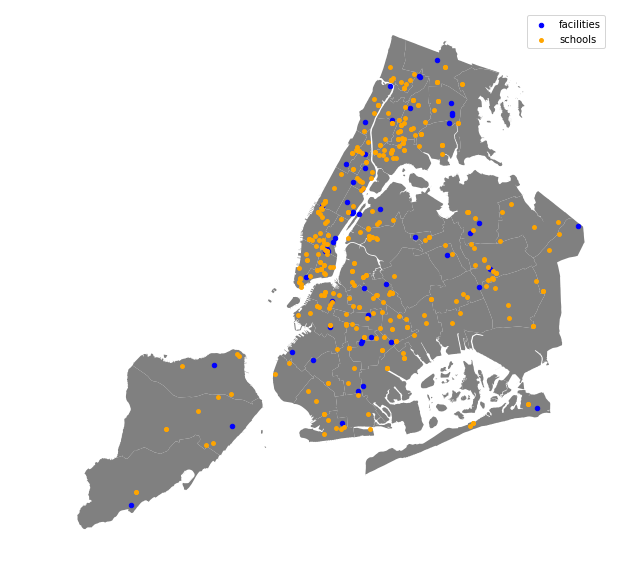

In [105]:
#ax = pl.figure(figsize=(10,10)).add_subplot(111)
# code for legend found on stack overflow: 
# stackoverflow.com/questions/19125722/adding-a-legend-to-pyplot-in-matplotlib-in-the-most-simple-manner-possible

f = cp(pumas, cmap=None, color='gray')
dischargeLocsGeo.plot(ax=f[1], marker='o', markersize=20, cmap=None, color='blue')
schoolsG.plot(ax=f[1], marker='o', markersize=15, cmap=None, color='orange')
plt.gca().legend(('facilities','schools'));

Figure 5: A map showing NYC PUMAs, overlayed with medical facilities (blue dots) and schools (orange dots). The medical facilities have been filtered to include only discharges for drug or asthma-related treatments. The schools included are from the 2010-2016 School Safety Report, a dataset detailing types of crimes that occur in NYC public schools. Those sparse, the medical facilties seem reasonably distributed in Manhattan, the Bronx, and parts of northern Brooklyn, but less so in Staten Island, southern Brooklyn/the Rockaways, and eastern Queens. Schools are more densely concentrated in Manhattan, with larger pockets of Brooklyn, Queens, and Staten Island without schools (perhaps more industrial or residential areas). 

**5.2 join hospital facilities and PUMA data**

In [106]:
# # making sure my two gdfs are the same crs

In [107]:
dischargeLocsGeo.crs

{'init': 'epsg:2263', 'no_defs': True}

In [108]:
pumas.crs

{'init': 'epsg:2263', 'no_defs': True}

In [109]:
# merging
pumaDischarges = gpd.sjoin(pumas, dischargeLocsGeo, how='inner', op="contains")

In [110]:
pumaDischarges.head()

,puma,shape_area,shape_leng,geometry,index_right,facility_id,facility_latitude,facility_longitude,Permanent Facility Id,asthmaRatio,drugRatio
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",6,1168,40.894569,-73.861420,1168.0,0.031091,0.062307
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",5,1165,40.857388,-73.846741,1165.0,0.050153,0.058599
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",51,3058,40.849575,-73.845055,3058.0,0.016384,0.002952
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",4,1175,40.847294,-73.844658,1175.0,0.000657,0.000000
5,4016,1.207135e+08,109477.751817,"POLYGON ((999782.7833862281 162246.8424071733,...",13,1293,40.613419,-73.948967,1293.0,0.022067,0.006342


In [111]:
pumaDischarges.shape

(54, 11)

In [112]:
pumaDischarges.drop(['index_right'], axis=1, inplace=True)

**5.3 join school data and puma**

In [113]:
# double checking crs for schools
schoolsG.crs

{'init': 'epsg:2263', 'no_defs': True}

In [114]:
# merging
alldata = gpd.sjoin(pumaDischarges, schoolsG, how='inner', op="contains")

In [115]:
alldata.head()

,puma,shape_area,shape_leng,geometry,facility_id,facility_latitude,facility_longitude,Permanent Facility Id,asthmaRatio,drugRatio,...,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,Latitude,Longitude
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",1168,40.894569,-73.86142,1168.0,0.031091,0.062307,...,0.0,0.0,0.0,0.0,0.0,0.0,376.0,370.333333,40.875953,-73.86197
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",1168,40.894569,-73.86142,1168.0,0.031091,0.062307,...,0.0,0.0,0.0,0.0,0.0,0.0,365.0,378.333333,40.875953,-73.86197
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",1168,40.894569,-73.86142,1168.0,0.031091,0.062307,...,0.0,0.0,0.0,0.0,0.0,0.0,378.0,375.333333,40.875953,-73.86197
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",1168,40.894569,-73.86142,1168.0,0.031091,0.062307,...,0.0,0.0,0.0,0.0,0.0,0.0,393.0,387.666667,40.875953,-73.86197
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",1168,40.894569,-73.86142,1168.0,0.031091,0.062307,...,0.0,0.0,0.0,0.0,0.0,0.0,391.0,378.333333,40.875953,-73.86197


In [116]:
# Averaging over PUMA 

In [117]:
alldataF = alldata[['puma', 'Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
       'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'SATmath', 'SATall', 'asthmaRatio', 'drugRatio']].groupby(by='puma').mean().reset_index()
alldataF.head()

,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,asthmaRatio,drugRatio
0,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,0.031091,0.062307
1,3704,0.000000,1.166667,0.722222,0.611111,0.444444,0.048333,0.185000,0.267222,0.125556,0.083889,412.666667,404.611111,0.022398,0.020517
2,3705,0.185185,0.987654,1.617284,0.432099,0.481481,0.056296,0.210617,0.312963,0.142222,0.096914,378.222222,373.629630,0.039932,0.201457
3,3707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,365.000000,356.833333,0.043208,0.011447
4,3709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.250000,364.111111,0.044483,0.003239


In [118]:
len(alldataF.puma.unique())

36

In [119]:
alldataF.shape

(36, 15)

**I lost about 20 PUMAs in the merge. This is 35% of my dataset. This may have negative implications on my analysis**

**Extra Credit : add income data**
- income data comes from the 2012 5 year ACS survey which can be accessed at the PUMA level
- 2008-2012 5-year data from American Community Survey
- I choose table B19013, median household income in the last 12 months, inflation adjusted in 2012 dollars

In [120]:
url = "https://api.census.gov/data/2012/acs5?get=" + 'B19013_001E' +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myapi
resp = requests.request('GET', url).content
total = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

In [121]:
acsinc = total[['B19013_001E', 'public use microdata area']]
acsinc12 = acsinc.rename(columns={'B19013_001E':'income', 'public use microdata area':'puma'})
acsinc12.head()

,income,puma
0,43745,100
1,48167,200
2,52908,300
3,49228,401
4,46059,402


In [122]:
pumas = gpd.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/geo_export_ad027962-faca-4b04-b5c8-88960606cb25.shp')

In [123]:
pumas['puma'] = pumas['puma'].astype(int)

In [124]:
pumaInc = pumas.merge(acsinc12, on='puma')

In [125]:
pumaInc.head()

,puma,shape_area,shape_leng,geometry,income
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,54898
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",46247
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,53032
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",45502
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,43039


In [126]:
pumaInc.shape

(55, 5)

**Merging Income Data**

In [127]:
alldataF['puma'] = alldataF['puma'].astype(int)

In [128]:
alldataInc = alldataF.merge(pumaInc, on='puma')

In [129]:
alldataInc.head()

,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,asthmaRatio,drugRatio,shape_area,shape_leng,geometry,income
0,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,0.031091,0.062307,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",46247
1,3704,0.000000,1.166667,0.722222,0.611111,0.444444,0.048333,0.185000,0.267222,0.125556,0.083889,412.666667,404.611111,0.022398,0.020517,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",45502
2,3705,0.185185,0.987654,1.617284,0.432099,0.481481,0.056296,0.210617,0.312963,0.142222,0.096914,378.222222,373.629630,0.039932,0.201457,1.224951e+08,68657.316149,POLYGON ((-73.87359713633828 40.83979855593596...,21591
3,3707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,365.000000,356.833333,0.043208,0.011447,4.228113e+07,37347.925798,"POLYGON ((-73.89735765412577 40.8587627349268,...",25833
4,3709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.250000,364.111111,0.044483,0.003239,1.241177e+08,73288.964465,(POLYGON ((-73.83667856364177 40.8175887629137...,38459


In [130]:
alldataInc.shape

(36, 19)

In [131]:
# making the column names a bit easier to work with in the future
alldataInc.columns = alldataInc.columns.str.replace(' ', '_')

**No PUMAs lost in income merge. Excellent!**

# PART II Visual and Exploratory analysis and Modeling

# 6 checking collinearity and covariance of the data

**6.1 plot SAT features against each other and assess collinearity**

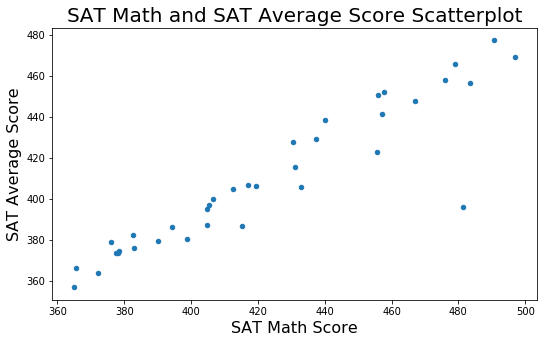

In [132]:
fig = pl.figure(figsize=(40,5))

ax1 = fig.add_subplot(141)
ax1.set_title('SAT Math and SAT Average Score Scatterplot', fontsize=20)
figure = alldataInc.plot(x='SATmath', y='SATall', kind='scatter', ax=ax1)
pl.xlabel('SAT Math Score', fontsize=16)
pl.ylabel('SAT Average Score', fontsize=16)
pl.legend()

Figure 6: A scatterplot of SAT Math and Composite scores (average of math, reading, and writing scores). SAT scores are from the 2012 SAT Results resource from NYC Open Data. Data were merged with schools from the 2010-2016 School Safety Report, and aggregated at the PUMA level. From the plot, we see a positive linear relationship between the math and composite score. Interpreting this plot with our earlier plots of SAT feature and crime, I am more suspicious that two two features are highly covariant.

In [133]:
modelSAT = smf.ols(formula='SATall ~ SATmath', data=alldataInc).fit()
print(modelSAT.summary())

                            OLS Regression Results                            
Dep. Variable:                 SATall   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     203.5
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           6.49e-16
Time:                        23:32:13   Log-Likelihood:                -142.72
No. Observations:                  36   AIC:                             289.4
Df Residuals:                      34   BIC:                             292.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     71.6458     23.761      3.015      0.0

**I feel comfortable using Pearson's R because I believe both features come from a normal distribution. Alpha=.05. However, the fact that may sample size is so small may make the resulting p-value unreliable.**

In [134]:
# Pearson's R test for continuous data
print ("Test of correlation between SAT Math and SAT Average Score:")
sp.stats.pearsonr(alldataInc.SATmath, alldataInc.SATall)

Test of correlation between SAT Math and SAT Average Score:


(0.92567111987003703, 6.4883210904769042e-16)

**DISCUSSION**: Based on the high R-squared value from the OLS regression, the high correlation coefficient from Pearson's R test, and visual evidence based on multiple features, my assessment is that SAT math and SAT average scores are collinear. Going forward, we need only use one of these measures to investigate the effects of crime, health, and income on test score. 

In [135]:
alldataInc.head()

,puma,Major_N,Oth_N,NoCrim_N,Prop_N,Vio_N,AvgOfMajor_N,AvgOfOth_N,AvgOfNoCrim_N,AvgOfProp_N,AvgOfVio_N,SATmath,SATall,asthmaRatio,drugRatio,shape_area,shape_leng,geometry,income
0,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,0.031091,0.062307,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",46247
1,3704,0.000000,1.166667,0.722222,0.611111,0.444444,0.048333,0.185000,0.267222,0.125556,0.083889,412.666667,404.611111,0.022398,0.020517,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",45502
2,3705,0.185185,0.987654,1.617284,0.432099,0.481481,0.056296,0.210617,0.312963,0.142222,0.096914,378.222222,373.629630,0.039932,0.201457,1.224951e+08,68657.316149,POLYGON ((-73.87359713633828 40.83979855593596...,21591
3,3707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,365.000000,356.833333,0.043208,0.011447,4.228113e+07,37347.925798,"POLYGON ((-73.89735765412577 40.8587627349268,...",25833
4,3709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.250000,364.111111,0.044483,0.003239,1.241177e+08,73288.964465,(POLYGON ((-73.83667856364177 40.8175887629137...,38459


**6.2 plot the SAT feature by PUMA against 3 of the crime features**
- Since we have already looked at major crime, average major crime, and non criminal crime, I chose other crimes, property crimes, and violent crimes.

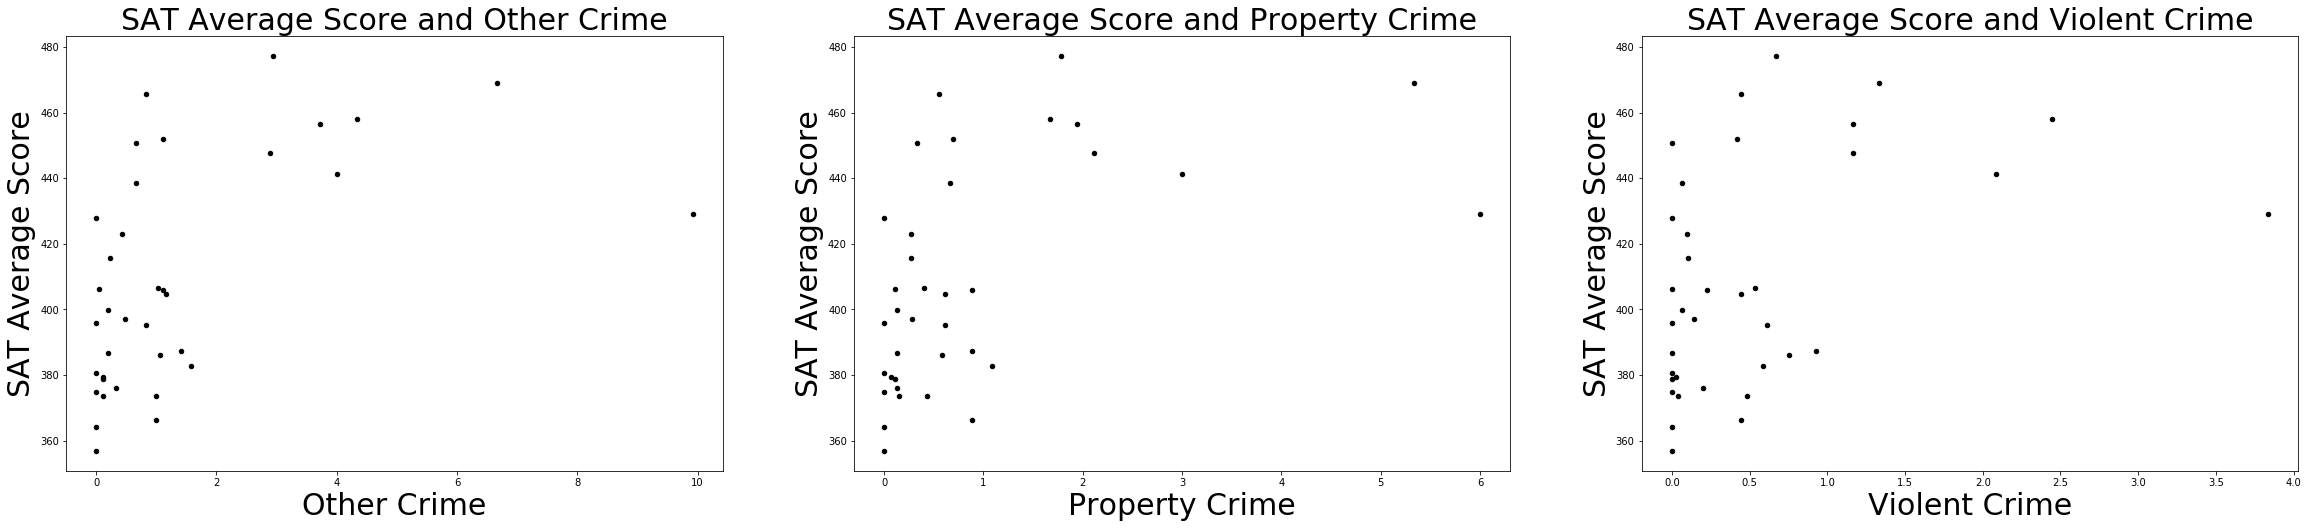

In [136]:
fig = pl.figure(figsize=(40,8))

ax1 = fig.add_subplot(131)
ax1.set_title('SAT Average Score and Other Crime', fontsize=30)
figure = alldataInc.plot(x='Oth_N', y='SATall', kind='scatter', c='black', ax=ax1)
pl.ylabel('SAT Average Score', fontsize=30)
pl.xlabel('Other Crime', fontsize=30)

ax2 = fig.add_subplot(132)
ax2.set_title('SAT Average Score and Property Crime', fontsize=30)
figure = alldataInc.plot(x='Prop_N', y='SATall', kind='scatter', c='black', ax=ax2)
pl.ylabel('SAT Average Score', fontsize=30)
pl.xlabel('Property Crime', fontsize=30)

ax3 = fig.add_subplot(133)
ax3.set_title('SAT Average Score and Violent Crime', fontsize=30)
figure = alldataInc.plot(x='Vio_N', y='SATall', kind='scatter', c='black', ax=ax3)
pl.ylabel('SAT Average Score', fontsize=30)
pl.xlabel('Violent Crime', fontsize=30);

Figure 7: Three different crime measures against SAT Average Score. Unfortunately, the School Safety Report does not elaborate on what 'other crime' entails. We only have 36 data points, so it's difficult to make an assessment about trend. Most of the data seem to lie along the vertical access, spread across the range of scores. However, as crimes increases, there does seem to be a gradual trend upward in SAT score towards the top of the plot - possibly suggesting a logrithmic relationship. My next plot will plot the features in log space to see if this helps in our visual inspection.

**Plotting in log space**

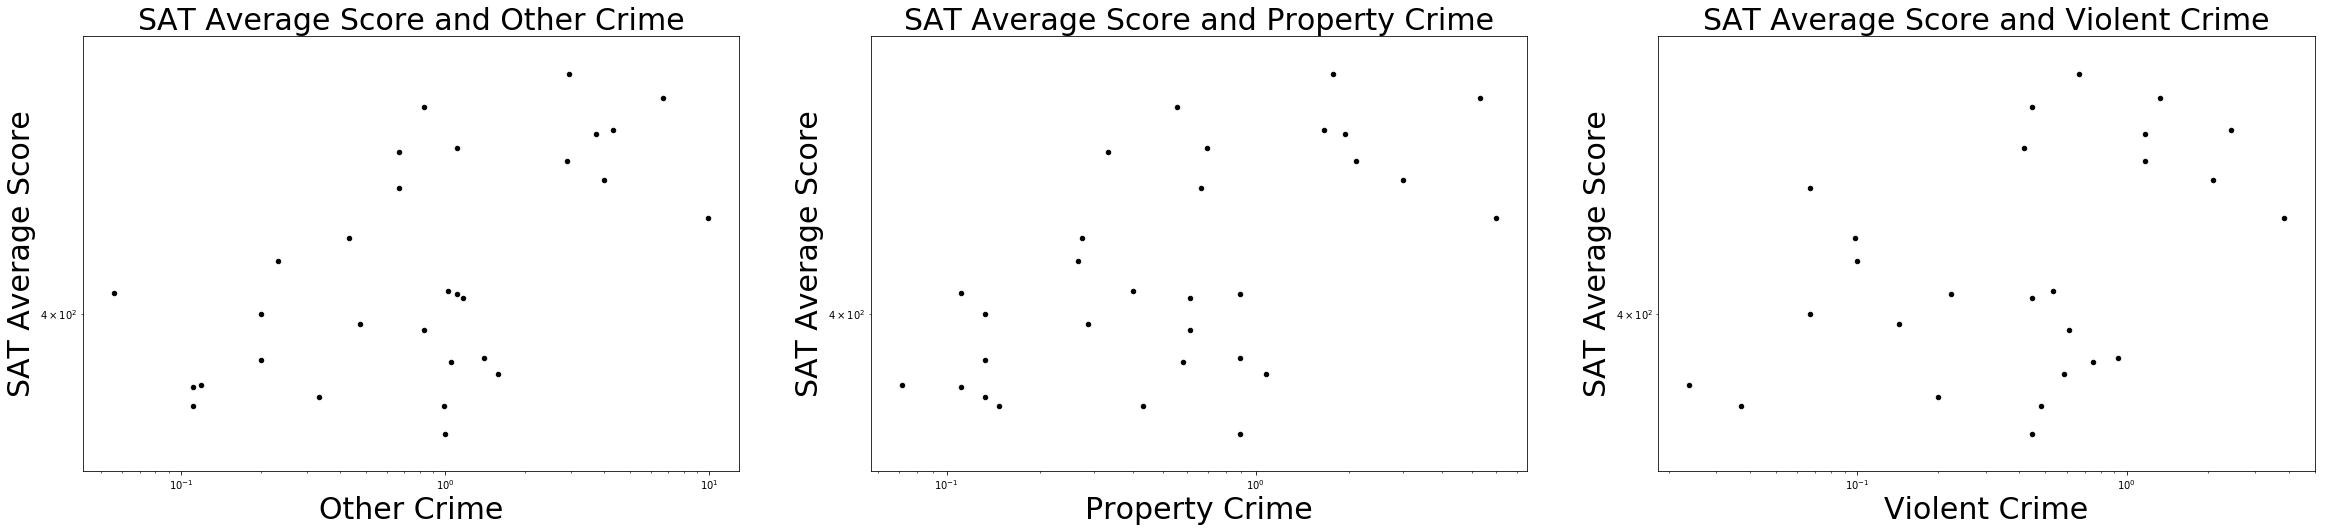

In [137]:
fig = pl.figure(figsize=(40,8))

ax1 = fig.add_subplot(131)
ax1.set_title('SAT Average Score and Other Crime', fontsize=30)
figure = alldataInc.plot(x='Oth_N', y='SATall', kind='scatter', c='black', ax=ax1, loglog=True)
pl.ylabel('SAT Average Score', fontsize=30)
pl.xlabel('Other Crime', fontsize=30)

ax2 = fig.add_subplot(132)
ax2.set_title('SAT Average Score and Property Crime', fontsize=30)
figure = alldataInc.plot(x='Prop_N', y='SATall', kind='scatter', c='black', ax=ax2, loglog=True)
pl.ylabel('SAT Average Score', fontsize=30)
pl.xlabel('Property Crime', fontsize=30)

ax3 = fig.add_subplot(133)
ax3.set_title('SAT Average Score and Violent Crime', fontsize=30)
figure = alldataInc.plot(x='Vio_N', y='SATall', kind='scatter', c='black', ax=ax3, loglog=True)
pl.ylabel('SAT Average Score', fontsize=30)
pl.xlabel('Violent Crime', fontsize=30);

Figure 8: Three different crime measures against SAT Average Score, plotted in log space. It's hard to say whether this is showing a trend or not, given our small sample size. The spread appears random, which would indicate no relationship between the crime features and SAT score. At this stage, I am not able to make further conjectures about these features' relationship to SAT score.

**6.3 plot the SAT feature against medical data**

- asthmaRatio, drugsRatio, and income

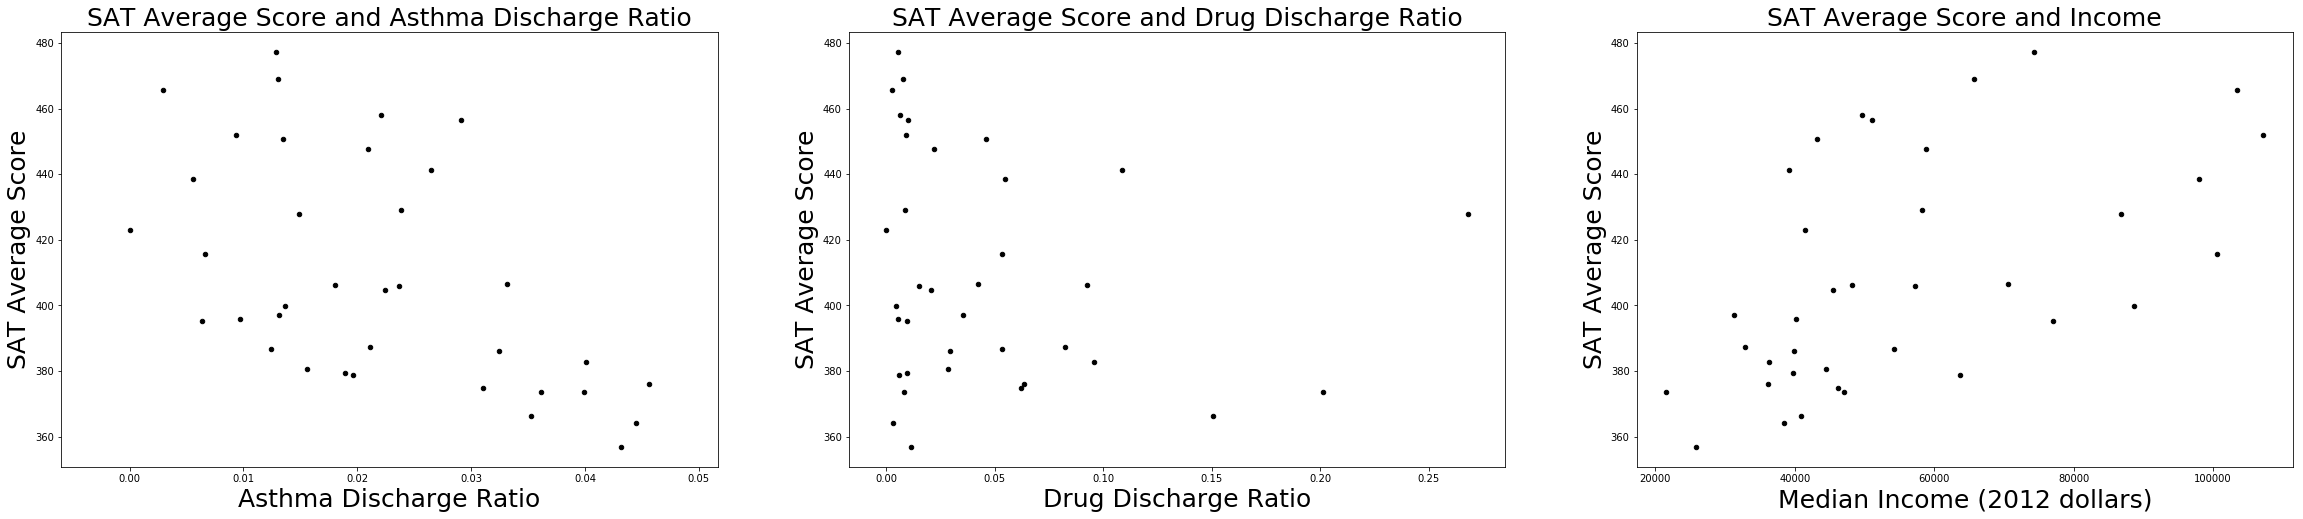

In [138]:
fig = pl.figure(figsize=(40,8))

ax1 = fig.add_subplot(131)
ax1.set_title('SAT Average Score and Asthma Discharge Ratio', fontsize=25)
figure = alldataInc.plot(x='asthmaRatio', y='SATall', kind='scatter', c='black', ax=ax1)
pl.ylabel('SAT Average Score', fontsize=25)
pl.xlabel('Asthma Discharge Ratio', fontsize=25)

ax2 = fig.add_subplot(132)
ax2.set_title('SAT Average Score and Drug Discharge Ratio', fontsize=25)
figure = alldataInc.plot(x='drugRatio', y='SATall', kind='scatter', c='black', ax=ax2)
pl.ylabel('SAT Average Score', fontsize=25)
pl.xlabel('Drug Discharge Ratio', fontsize=25)

ax3 = fig.add_subplot(133)
ax3.set_title('SAT Average Score and Income', fontsize=25)
figure = alldataInc.plot(x='income', y='SATall', kind='scatter', c='black', ax=ax3)
pl.ylabel('SAT Average Score', fontsize=25)
pl.xlabel('Median Income (2012 dollars)', fontsize=25);

Figure 9: Assessing the relationship between asthma discharge ratio, drug dischage ratio, income, and SAT Average Score. Drug and asthma ratios were calculated based on total discharge figures from the 2012 Hospital Inpatient Discharges (SPARCS De-Identified) dataset. Median income data is from the 2012 American Community Survey (5-year). We see more defined trends in these plots, specifically with asthma ratio and income. As asthma discharge rate increases, SAT score decreases. And as income increases, SAT score increases. Both of these trends we might expect: areas with high incidence of asthma may mean students are missing school, casuing their performance to suffer. Higher income may mean more access to resources such as SAT prep courses. The relationship between drug discharge ratio and score is less clear. I would expect to see a negative relationship between the two. 

**Extra Credit: plot a covariance matrix of all features**

In [139]:
covcols = alldataInc[['income', 'Major_N', 'Oth_N', 'NoCrim_N', 'Prop_N', 'Vio_N',
       'AvgOfMajor_N', 'AvgOfOth_N', 'AvgOfNoCrim_N', 'AvgOfProp_N',
       'AvgOfVio_N', 'SATmath', 'SATall', 'asthmaRatio', 'drugRatio']]

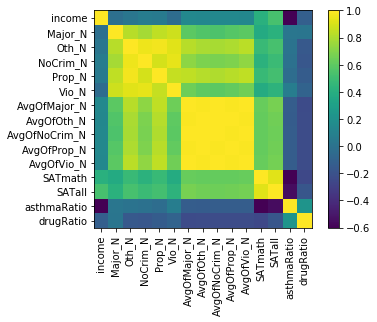

In [140]:
ax = pl.figure().add_subplot(111)
cax = ax.imshow(covcols.corr())
pl.colorbar(cax)
ax.set_xticks(range(len(covcols.columns)))
ax.set_xticklabels(covcols.columns, rotation=90)
ax.set_yticks(range(len(covcols.columns)))
ax.set_yticklabels(covcols.columns);

Figure 7: Covariance matrix of our final features. As confirmed before, SAT math and SAT all are highly covariant. As suspected before, asthma and the SAT features have a negative relationship. The drugs discharge ratio is largely unlinked to any other variables except asthma ratios. All of the average crime features are perfectly covariant with one another and the non-average crime features are highly covariant, but less so than the averages. 

# 7 Mapping

- Plot choropleths (maps where each area is colorcoded by the value of a variable) of:
    - the SAT features,
    - the 3 chosen school crime features
    - the two medical discharge fieatures
    - the income if you have it from the extra credit

**SAT Features**

In [141]:
alldataInc.head()

,puma,Major_N,Oth_N,NoCrim_N,Prop_N,Vio_N,AvgOfMajor_N,AvgOfOth_N,AvgOfNoCrim_N,AvgOfProp_N,AvgOfVio_N,SATmath,SATall,asthmaRatio,drugRatio,shape_area,shape_leng,geometry,income
0,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,0.031091,0.062307,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",46247
1,3704,0.000000,1.166667,0.722222,0.611111,0.444444,0.048333,0.185000,0.267222,0.125556,0.083889,412.666667,404.611111,0.022398,0.020517,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",45502
2,3705,0.185185,0.987654,1.617284,0.432099,0.481481,0.056296,0.210617,0.312963,0.142222,0.096914,378.222222,373.629630,0.039932,0.201457,1.224951e+08,68657.316149,POLYGON ((-73.87359713633828 40.83979855593596...,21591
3,3707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,365.000000,356.833333,0.043208,0.011447,4.228113e+07,37347.925798,"POLYGON ((-73.89735765412577 40.8587627349268,...",25833
4,3709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.250000,364.111111,0.044483,0.003239,1.241177e+08,73288.964465,(POLYGON ((-73.83667856364177 40.8175887629137...,38459


In [142]:
alldataIncGeo = gpd.GeoDataFrame(alldataInc, geometry='geometry')

In [143]:
alldataIncGeo.crs = from_epsg(4326)
alldataIncGeo.to_crs(epsg=2263, inplace=True)

In [144]:
alldataIncGeo.head()

,puma,Major_N,Oth_N,NoCrim_N,Prop_N,Vio_N,AvgOfMajor_N,AvgOfOth_N,AvgOfNoCrim_N,AvgOfProp_N,AvgOfVio_N,SATmath,SATall,asthmaRatio,drugRatio,shape_area,shape_leng,geometry,income
0,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,0.031091,0.062307,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",46247
1,3704,0.000000,1.166667,0.722222,0.611111,0.444444,0.048333,0.185000,0.267222,0.125556,0.083889,412.666667,404.611111,0.022398,0.020517,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",45502
2,3705,0.185185,0.987654,1.617284,0.432099,0.481481,0.056296,0.210617,0.312963,0.142222,0.096914,378.222222,373.629630,0.039932,0.201457,1.224951e+08,68657.316149,"POLYGON ((1019225.58178711 245263.8524169383, ...",21591
3,3707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,365.000000,356.833333,0.043208,0.011447,4.228113e+07,37347.925798,"POLYGON ((1012642.970825195 252164.6224364594,...",25833
4,3709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.250000,364.111111,0.044483,0.003239,1.241177e+08,73288.964465,"(POLYGON ((1029456.00079346 237188.9177855959,...",38459


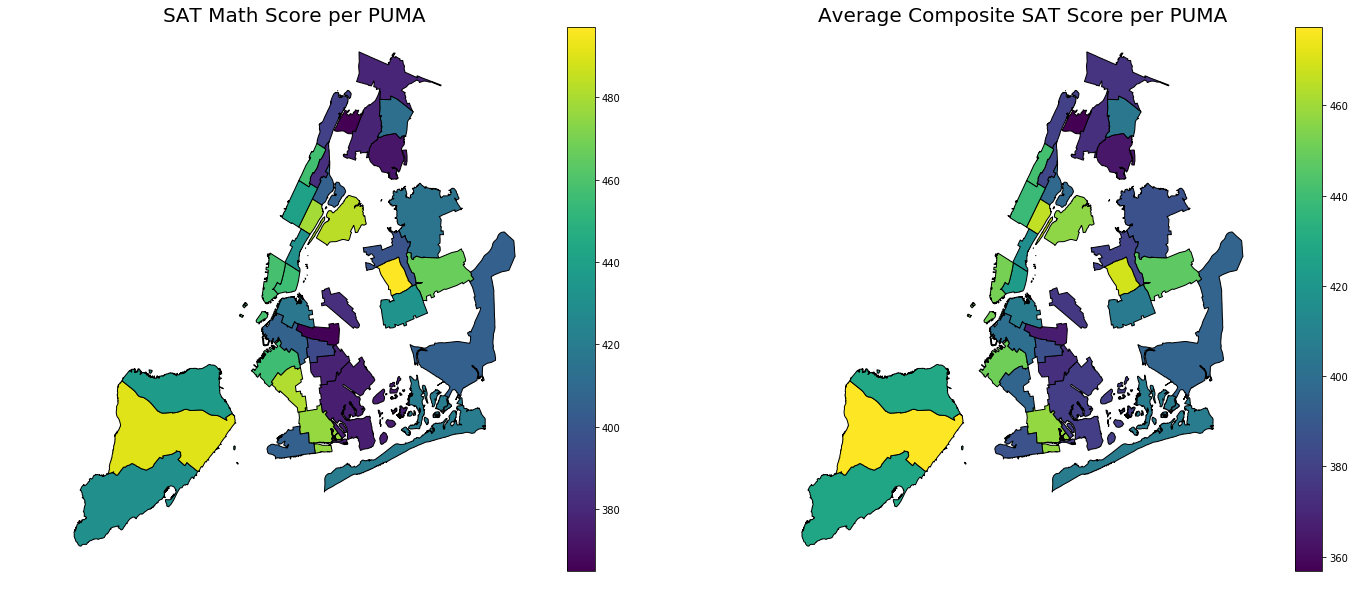

In [145]:
fig = pl.figure(figsize=(50,10))

ax1 = fig.add_subplot(141)
ax1.set_title('SAT Math Score per PUMA', fontsize=20)
alldataIncGeo.plot(column='SATmath', cmap='viridis', ax=ax1, legend=True, edgecolor='black')
ax1.axis('off')

ax2 = fig.add_subplot(142)
ax2.set_title('Average Composite SAT Score per PUMA', fontsize=20)
alldataIncGeo.plot(column='SATall', cmap='viridis', ax=ax2, legend=True, edgecolor='black')
ax2.axis('off');

Figure 8: Choropleths of 2012 SAT Math and SAT Composite scores in NYC public schools in which a crime occurred between 2010-2016, per the NYC School Safety Report, average across PUMA. In both plots, lighter areas indicate higher scores. Because of earlier data wrangling, our plots only show 36 of the 55 NYC PUMAs. From our limited view, we can see comparatively higher scores in Manhattan compared to the Bronx and parts of eastern Brooklyn. However, sections of north Brooklyn, Staten Island, and Queens show high average scores as well. Further spatial interpretations are limited given the missing data. Once again, we observe that the maps are very similar, since the features are highly covariant. 

**Crime Features**

- Major N, AvgOfNoCrim N, AvgOfMajor N
- Since all crime features are highly covariant, I chose the three that I was most interested in. 

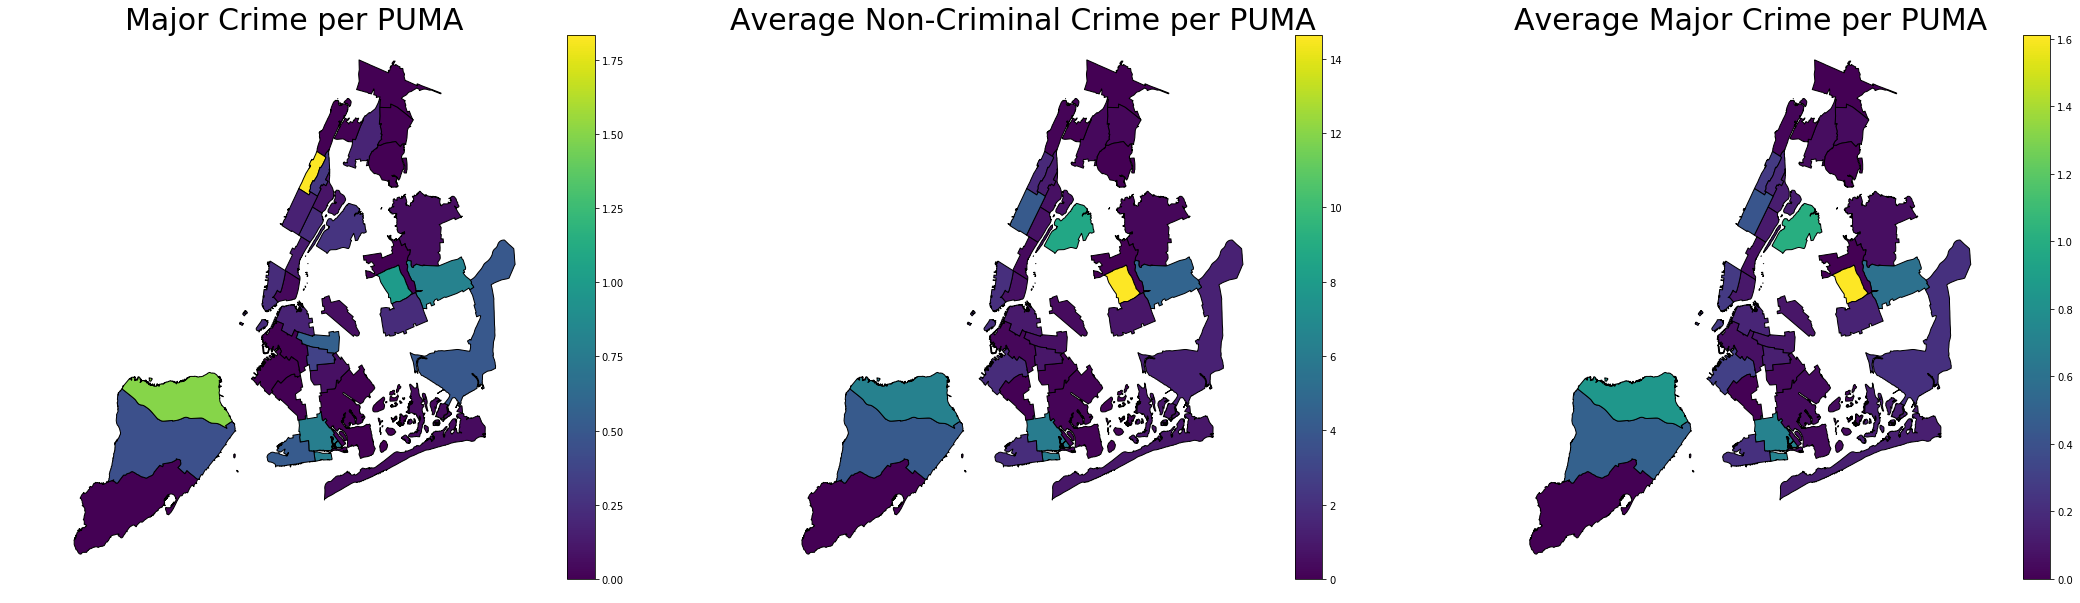

In [146]:
fig = pl.figure(figsize=(50,10))

ax1 = fig.add_subplot(141)
ax1.set_title('Major Crime per PUMA', fontsize=30)
alldataIncGeo.plot(column='Major_N', cmap='viridis', ax=ax1, legend=True, edgecolor='black')
ax1.axis('off')

ax2 = fig.add_subplot(142)
ax2.set_title('Average Non-Criminal Crime per PUMA', fontsize=30)
alldataIncGeo.plot(column='AvgOfNoCrim_N', cmap='viridis', ax=ax2, legend=True, edgecolor='black')
ax2.axis('off')

ax3 = fig.add_subplot(143)
ax3.set_title('Average Major Crime per PUMA', fontsize=30)
alldataIncGeo.plot(column='AvgOfMajor_N', cmap='viridis', ax=ax3, legend=True, edgecolor='black')
ax3.axis('off');

Figure 9: Choropleths of crime metrics in NYC public schools per PUMA, averaged across PUMAs. In all plots, a lighter color represents a higher amount of crime. As mentioned previously, becasue of earlier data wrangling the plots only show 36 of the 55 NYC PUMAs. From what we can see, most of the schools across the available PUMAs have low incidents of crime, whether 'major' or non-criminal. In each of the plots, there is one puma that has comparatively high crime incidence: in the first plot, a PUMA in Upper Manhattan or the Bronx, and in the second and third plots, the same PUMA in Queens.  

**Medical Features**
- the two medical discharge features

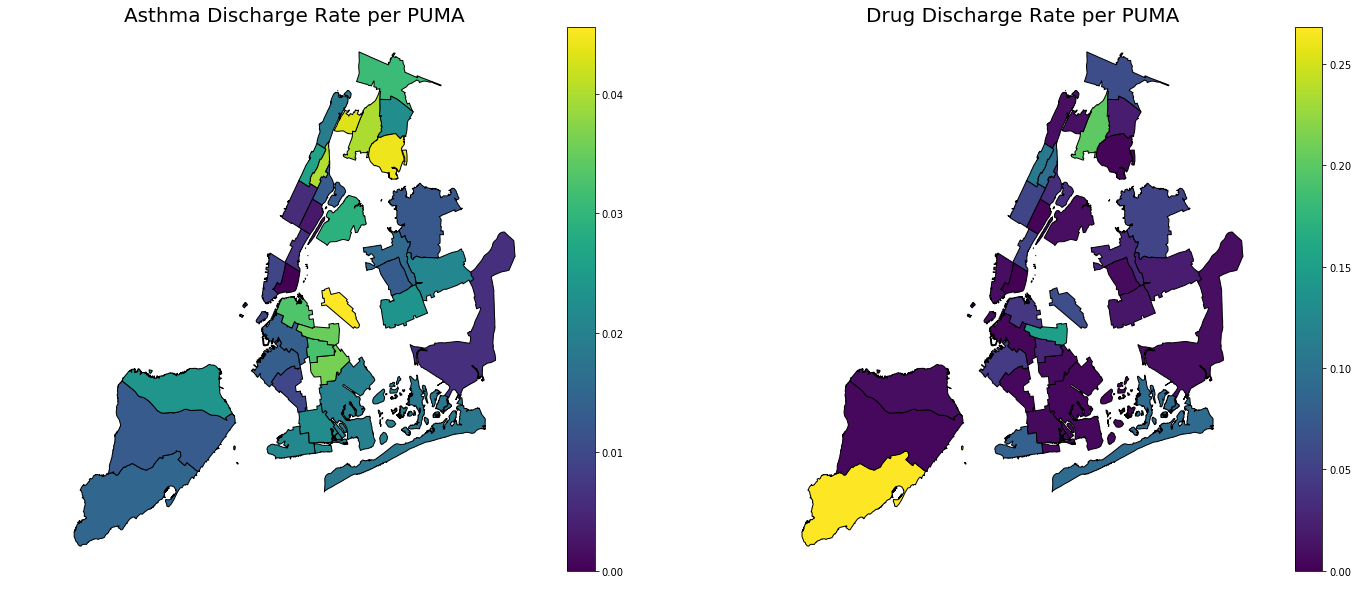

In [147]:
fig = pl.figure(figsize=(50,10))

ax1 = fig.add_subplot(141)
ax1.set_title('Asthma Discharge Rate per PUMA', fontsize=20)
alldataIncGeo.plot(column='asthmaRatio', cmap='viridis', ax=ax1, legend=True, edgecolor='black')
ax1.axis('off')

ax2 = fig.add_subplot(142)
ax2.set_title('Drug Discharge Rate per PUMA', fontsize=20)
alldataIncGeo.plot(column='drugRatio', cmap='viridis', ax=ax2, legend=True, edgecolor='black')
ax2.axis('off');

Figure 10: Average asthma and drug discharge ratios across NYC PUMAs. Data are from the 2012 Statewide Planning and Research Cooperative System (SPARCS) De-Identified dataset, which provides basic record level detail for the discharge. Original dataset was filtered by the 5 NYC counties. Again, we are only viewing 36/55 PUMAs. In all plots, a lighter color represents a higher incidence. Astma discharge rate is highest in the Bronx and eastern Brooklyn. A section of Staten Island has a comparatively high drug discharge rate, along with a section of the Bronx. Otherwise, drug discharge rate is low across the five boroughs

**Income**

(None,
 <matplotlib.legend.Legend at 0x7f208cd09b70>)

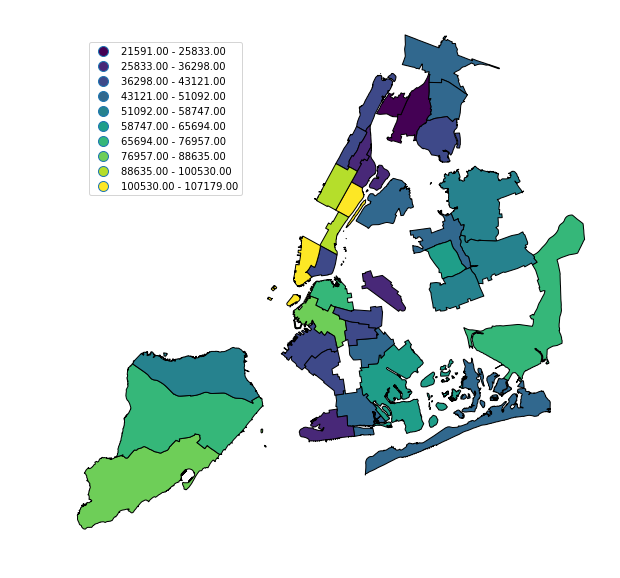

In [148]:
cp(alldataIncGeo, column='income', cmap='viridis', scheme='fisher_jenks', edgecolor='black')

Figure 11: Inflation-adjusted median income in the last 12 months, 2008-2012 American Community Survey. Again, we are only viewing 36/55 PUMAs. Yellow and light green colors represent a higher amount of median income, while blues and purples represent lower incomes. We observe the highest incomes in Manhattan and the lowest in parts of the Bronx and southern Brooklyn. 

**Include plot with all 8 maps (2 row by 4 columns?)**

# 8 start with linear modeling

**8.1 create a multivariate-linear model using only the crime in school features, but using all 10 of them, predicting the chosen SAT feature**
- I am choosing to predict the SAT Average Score

**Need to standardize model in order to interpret coefficients**

In [149]:
# preprocessing data for modeling

dataModeling = alldataIncGeo[['puma', 'SATmath', 'SATall', 'Major_N', 'Oth_N', 'NoCrim_N', 'Prop_N', 'Vio_N', 'AvgOfMajor_N',\
'AvgOfOth_N', 'AvgOfNoCrim_N', 'AvgOfProp_N', 'AvgOfVio_N', 'drugRatio', 'asthmaRatio', 'income']]
dataProcessed = pd.DataFrame(columns=dataModeling.columns, data=preprocessing.scale(dataModeling))

In [150]:
dataProcessed.head()

,puma,SATmath,SATall,Major_N,Oth_N,NoCrim_N,Prop_N,Vio_N,AvgOfMajor_N,AvgOfOth_N,AvgOfNoCrim_N,AvgOfProp_N,AvgOfVio_N,drugRatio,asthmaRatio,income
0,-1.610413,-1.132497,-1.022429,-0.700413,-0.674279,-0.630102,-0.661438,-0.667691,-0.720939,-0.644482,-0.622485,-0.669463,-0.690845,0.289120,0.773532,-0.417054
1,-1.596222,-0.259451,-0.136005,-0.700413,-0.110010,-0.407735,-0.208676,-0.113790,-0.577066,-0.529136,-0.532947,-0.540034,-0.559788,-0.426705,0.066154,-0.450081
2,-1.589127,-1.141029,-1.055402,-0.259602,-0.196591,-0.132152,-0.341303,-0.067631,-0.553363,-0.513164,-0.517621,-0.522854,-0.539440,2.672622,1.492995,-1.510081
3,-1.574937,-1.479441,-1.553844,-0.700413,-0.674279,-0.630102,-0.661438,-0.667691,-0.720939,-0.644482,-0.622485,-0.669463,-0.690845,-0.582065,1.759612,-1.322029
4,-1.560747,-1.293883,-1.337871,-0.700413,-0.674279,-0.630102,-0.661438,-0.667691,-0.720939,-0.644482,-0.622485,-0.669463,-0.690845,-0.722659,1.863321,-0.762305


In [151]:
# making sure data is standardized with mean 0 
dataProcessed.mean(axis=0)

puma             3.947460e-16
SATmath         -2.625215e-16
SATall          -1.048544e-16
Major_N          4.317534e-17
Oth_N           -4.934325e-17
NoCrim_N        -9.560254e-17
Prop_N          -3.083953e-17
Vio_N           -7.093092e-17
AvgOfMajor_N     1.541976e-18
AvgOfOth_N      -6.630499e-17
AvgOfNoCrim_N   -6.938894e-17
AvgOfProp_N     -2.312965e-17
AvgOfVio_N       8.172475e-17
drugRatio       -1.295260e-16
asthmaRatio      6.784696e-17
income           1.588236e-16
dtype: float64

In [152]:
# making sure data is standardized with stdev 1
dataProcessed.std(axis=0)

puma             1.014185
SATmath          1.014185
SATall           1.014185
Major_N          1.014185
Oth_N            1.014185
NoCrim_N         1.014185
Prop_N           1.014185
Vio_N            1.014185
AvgOfMajor_N     1.014185
AvgOfOth_N       1.014185
AvgOfNoCrim_N    1.014185
AvgOfProp_N      1.014185
AvgOfVio_N       1.014185
drugRatio        1.014185
asthmaRatio      1.014185
income           1.014185
dtype: float64

In [153]:
satAvgmod = smf.ols(formula='SATall ~ Major_N + Oth_N + NoCrim_N + Prop_N + Vio_N + AvgOfMajor_N +\
AvgOfOth_N + AvgOfNoCrim_N + AvgOfProp_N + AvgOfVio_N', data=dataProcessed).fit()

In [154]:
print(satAvgmod.summary())

                            OLS Regression Results                            
Dep. Variable:                 SATall   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     3.231
Date:                Mon, 17 Dec 2018   Prob (F-statistic):            0.00840
Time:                        23:32:22   Log-Likelihood:                -36.150
No. Observations:                  36   AIC:                             94.30
Df Residuals:                      25   BIC:                             111.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept     -1.284e-16      0.132  -9.72e-16

**DISCUSSION** An OLS regression using all 10 crime measures to predict SAT average score (SATall). This model explains 56% of the varinace in SATall. As each coefficient contains 0 in the 95% confidence interval,  they are not significant. We will need to refine the model to see if this helps us learn more about the relationship between these measures and SAT score.  

**8.2 add drugs and asthma discharge data and create a new multilinear model**

In [155]:
satAvgmod2 = smf.ols(formula='SATall ~ Major_N + Oth_N + NoCrim_N + Prop_N + Vio_N + AvgOfMajor_N +\
AvgOfOth_N + AvgOfNoCrim_N + AvgOfProp_N + AvgOfVio_N + drugRatio + asthmaRatio', data=dataProcessed).fit()

In [156]:
print(satAvgmod2.summary())

                            OLS Regression Results                            
Dep. Variable:                 SATall   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     6.755
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           4.86e-05
Time:                        23:32:22   Log-Likelihood:                -23.912
No. Observations:                  36   AIC:                             73.82
Df Residuals:                      23   BIC:                             94.41
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept     -1.284e-16      0.098  -1.31e-15

**DISCUSSION** An OLS regression using all 10 crime measures and drug and asthma discharge ratios to predict SAT average score (SATall). The R-squared value has increased, our measures are explaining 78% of the variance in SATall. Two measures, property crimes and asthma ratio, are significant in this model. The coefficient for asthma ratio is negative, which is consistent with what we observed in the covariance matrix and earlier scatter plots. The coefficient for property crimes is also negative, which is something we would expect: the convention knowledge is that crime is disruptive to learning, impacting measures standardized test scores.

**Extra credit: if you have income add income data and create a new multilinear model**

In [157]:
satAvgmod3 = smf.ols(formula='SATall ~ Major_N + Oth_N + NoCrim_N + Prop_N + Vio_N + AvgOfMajor_N +\
AvgOfOth_N + AvgOfNoCrim_N + AvgOfProp_N + AvgOfVio_N + drugRatio + asthmaRatio + income', data=dataProcessed).fit()

In [158]:
print(satAvgmod3.summary())

                            OLS Regression Results                            
Dep. Variable:                 SATall   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     9.682
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           2.64e-06
Time:                        23:32:22   Log-Likelihood:                -16.787
No. Observations:                  36   AIC:                             61.57
Df Residuals:                      22   BIC:                             83.74
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept     -1.284e-16      0.082  -1.56e-15

**DISCUSSION** An OLS regression using all 10 crime measures, drug and asthma discharge ratios, and income to predict SAT average score (SATall). The R-squared value has increased again, our measures are explaining 85% of the variance in SATall. Five measures are now significant in this model: major crimes, other crimes, property crimes, violent crimes, and income. Astham is no longer significant. Income, major crimes and other crimes have positive effects on SAT score, and the coefficients for major and other crime have slightly increased from the previous model. Further, non-criminal crime, property crime, and violent crime have negative effects, these coefficients have increased in size from the previous model as well. It's unclear at this stage why certain types of crime would affect test score differently. We may be overfitting our data.

# 9 compare the linear models + extra credit

- I am using a likelihood ratio. This is an appropriate test because these models are nested. 
- Using two LRs:
    - first compares the simplest model (model 1) and the second model (model 2)
    - then, compare model 2 and model 3

**Alpha = .05**

In [159]:
# first LR test (restricted model goes in parathesis)
satAvgmod2.compare_lr_test(satAvgmod)

(24.476818472465453, 4.8409032331240428e-06, 2.0)

**Interpretation:** At the .05 significance level, our critical value from the Chi Squared distriubtion with 2 degrees of freedom is 5.991. Since our statistic 24.4 in greater than our critical value, we reject the null hypothesis that the restricted model is better than our more complex model with drug/asthma discharge ratios. 

In [160]:
# second LR test
satAvgmod3.compare_lr_test(satAvgmod2)

(14.248361094440924, 0.00016020025210903955, 1.0)

**Interpretation:** At the .05 significance level, our critical value from the Chi Squared distriubtion with 1 degree of freedom is 3.841. Since our statistic 14.2 in greater than our critical value, we reject the null hypothesis that the restricted model is better than our more complex model with drug/asthma discharge ratios and income.  

**Extra credit: if you did the income model, based on this result is there another multilinear model you would like to run?**

- Yes, perhaps it would be interesting to add in puma for a fourth multivariate model, since the more complex model was 'worth it' according to the Likelihood Ratio. It would be interesting to see if an additional feature tells us anything further about SAT score

In [161]:
# fourth multivariate model
satAvgmod4 = smf.ols(formula='SATall ~ Major_N + Oth_N + NoCrim_N + Prop_N + Vio_N + AvgOfMajor_N +\
AvgOfOth_N + AvgOfNoCrim_N + AvgOfProp_N + AvgOfVio_N + drugRatio + asthmaRatio + income + puma', data=dataProcessed).fit()

In [162]:
print(satAvgmod4.summary())

                            OLS Regression Results                            
Dep. Variable:                 SATall   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     10.04
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           2.34e-06
Time:                        23:32:22   Log-Likelihood:                -14.363
No. Observations:                  36   AIC:                             58.73
Df Residuals:                      21   BIC:                             82.48
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept     -1.284e-16      0.079  -1.63e-15

**Discussion** Our R-squared is only marginally higher. Let's see what the LR thinks, using the same alpha = .05

In [163]:
# second LR test
satAvgmod4.compare_lr_test(satAvgmod3)

(4.8496343226320278, 0.02765199391940901, 1.0)

**Interpretation:** At the .05 significance level, our critical value from the Chi Squared distriubtion with 1 degree of freedom is 3.841. Since our statistic 4.8 in greater than our critical value, we reject the null hypothesis that the restricted model is better than our more complex model with drug/asthma discharge ratios, income, and now PUMA. 

**Additional investigation:** In addition, we could also have introduced polynomial features (such as major crimes^2) to investigate non-linearities.

# 10 random forest regression on school-related data only

**10.1 create a random forest model using only the crime in school data, but using all 10 crime in school features** 

- I've already preprocessed the data, so I can just slice my current df to only include crime features
- creating binary label : SAT scores above or below the mean
- due to the small sample size, I chose a 50/50 split to give the training model a bit more observations to work with

In [164]:
y = dataProcessed.SATall > dataProcessed.SATall.mean()

In [165]:
# only using crime features
X = dataProcessed[['Major_N', 'Oth_N', 'NoCrim_N', 'Prop_N', 'Vio_N', 'AvgOfMajor_N',
                    'AvgOfOth_N', 'AvgOfNoCrim_N', 'AvgOfProp_N', 'AvgOfVio_N']]
y = y.astype(int).values

In [166]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [167]:
# Supervised transformation based on random forests
rf = rfc(max_depth=3, n_estimators=100, random_state=12345)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

In [168]:
rf.score(X_train, y_train)

0.88888888888888884

In [169]:
rf.score(X_test, y_test)

0.66666666666666663

In [170]:
y_pred_rf = rf.predict(X_test)

**MODEL ACCURACY** My models perform reasonably well on the training data and worse on the test set, which may mean my model is overfitting.

In [171]:
average_precision = average_precision_score(y_test, y_pred_rf)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.69


**Confusion Matrix** 

confusion matrix:
 [[7 5]
 [1 5]]


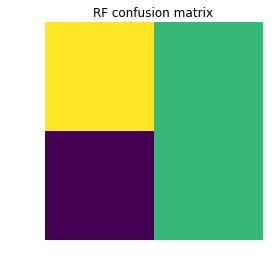

In [172]:
ax = pl.figure().add_subplot(111)
ax.imshow(confusion_matrix(y_test, y_pred_rf), cmap='viridis')
ax.set_title("RF confusion matrix")
ax.axis('off')

# ax = pl.figure().add_subplot(111)
# ax.imshow(np.log10(confusion_matrix(y_test, y_pred_rf)), cmap='viridis')
# ax.set_title("RF confusion matrix in log space\n(for enhanced visibility)")
# ax.axis('off');

print("confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))

**PRECISION AND RECALL** The model generated 5 False Positives and 1 False Negative. Given the small dataset, it's hard to say whether 70% precision-accuracy score is poor. I plot the ROC curve to visualize this below.

In [173]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf, drop_intermediate=False)

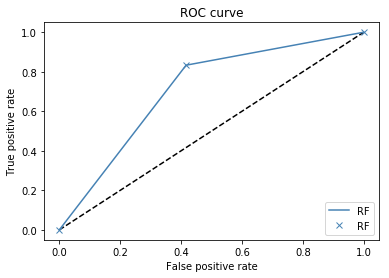

In [174]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, '-', color='SteelBlue', label='RF')
plt.plot(fpr_rf, tpr_rf, 'x', color='SteelBlue', label='RF')
#plt.plot(fpr_gdb, tpr_gdb, '-', color='IndianRed',label='GBT')
#plt.plot(fpr_gdb, tpr_gdb, 'x', color='IndianRed',label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc=4)
plt.show()

Figure 12: ROC curve to visualize the diagnostic ability of the model. The most desireable is a point at (1,0) on the ROC curve. However, this model has about half the false positive detection rate as true positive detection rate. 

**10.2 measure the feature importance of the features in this model to select the 3 most predictive features**
- You can use the code featureImportancePlotter.py if you want to visualize feature importance

In [175]:
rf.feature_importances_

array([ 0.05330817,  0.0456023 ,  0.08336862,  0.06357897,  0.01577512,
        0.13316342,  0.14730428,  0.13464486,  0.1365752 ,  0.18667907])

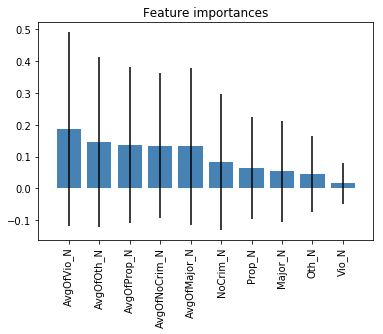

In [176]:
labels = ['Major_N', 'Oth_N', 'NoCrim_N', 'Prop_N', 'Vio_N', 'AvgOfMajor_N',
                    'AvgOfOth_N', 'AvgOfNoCrim_N', 'AvgOfProp_N', 'AvgOfVio_N']
featureImportancePlot(rf, labels)

Figure 13: Feature importance for predicting SAT average score. Of the ten crime measures, the three most predictive features are Average of Violent Crime, Average of Other Crime, and Average of Property Crime. Many of the indicators are close in their influence on SAT score, especially between the second through fifth measures. So, picking the 'top three' I don't think will help us that much, since most likely any of the top five would work. 

# 11 random forest with crime and medical (and income if you have it) features

**11.1 create a random forest model that only uses the 3 most predictive features about school crimes and the health features**
- due to the small sample size, I chose a 50/50 split to give the training model a bit more observations to work with

In [177]:
dataProcessed.head()

,puma,SATmath,SATall,Major_N,Oth_N,NoCrim_N,Prop_N,Vio_N,AvgOfMajor_N,AvgOfOth_N,AvgOfNoCrim_N,AvgOfProp_N,AvgOfVio_N,drugRatio,asthmaRatio,income
0,-1.610413,-1.132497,-1.022429,-0.700413,-0.674279,-0.630102,-0.661438,-0.667691,-0.720939,-0.644482,-0.622485,-0.669463,-0.690845,0.289120,0.773532,-0.417054
1,-1.596222,-0.259451,-0.136005,-0.700413,-0.110010,-0.407735,-0.208676,-0.113790,-0.577066,-0.529136,-0.532947,-0.540034,-0.559788,-0.426705,0.066154,-0.450081
2,-1.589127,-1.141029,-1.055402,-0.259602,-0.196591,-0.132152,-0.341303,-0.067631,-0.553363,-0.513164,-0.517621,-0.522854,-0.539440,2.672622,1.492995,-1.510081
3,-1.574937,-1.479441,-1.553844,-0.700413,-0.674279,-0.630102,-0.661438,-0.667691,-0.720939,-0.644482,-0.622485,-0.669463,-0.690845,-0.582065,1.759612,-1.322029
4,-1.560747,-1.293883,-1.337871,-0.700413,-0.674279,-0.630102,-0.661438,-0.667691,-0.720939,-0.644482,-0.622485,-0.669463,-0.690845,-0.722659,1.863321,-0.762305


In [178]:
# only using 3 most important crime features plus medical and income
X1 = dataProcessed[['drugRatio', 'asthmaRatio', 'income',
                    'AvgOfOth_N', 'AvgOfVio_N', 'AvgOfProp_N']]

In [179]:
y1 = dataProcessed.SATall > dataProcessed.SATall.mean()

In [180]:
# splitting the data
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.5)

In [181]:
# Supervised transformation based on random forests
rf1 = rfc(max_depth=3, n_estimators=100, random_state=12345)
rf1.fit(X1_train, y1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

**11.2 evaluate the performance of the model**

In [182]:
rf1.score(X1_train, y1_train)

1.0

In [183]:
rf1.score(X1_test, y1_test)

0.94444444444444442

In [184]:
y1_pred_rf = rf1.predict(X1_test)

**Model Accuracy** This model is overfitting, since it performs perfectly on the training data. It still performs quite well on the test set. We examine the precision/recall score below to interpret precision. 

In [185]:
average_precision1 = average_precision_score(y1_test, y1_pred_rf)

print('Average precision-recall score: {0:0.2f}'.format(average_precision1))

Average precision-recall score: 0.94


**Confusion Matrix**

confusion matrix
 [[9 1]
 [0 8]]


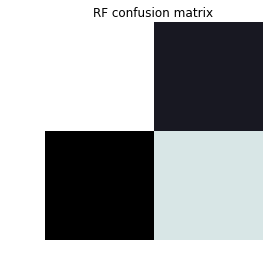

In [186]:
ax = pl.figure().add_subplot(111)
ax.imshow(confusion_matrix(y1_test, y1_pred_rf), cmap='bone')
ax.set_title("RF confusion matrix")
ax.axis('off')

# ax = pl.figure().add_subplot(111)
# ax.imshow(np.log10(confusion_matrix(y_test, y_pred_rf)), cmap='bone')
# ax.set_title("RF confusion matrix in log space\n(for enhanced visibility)")
# ax.axis('off');

print("confusion matrix\n", confusion_matrix(y1_test, y1_pred_rf))

**PRECISION AND RECALL** The model generated 1 False Positives and 0 False Negatives, a better result than previously. In the context of only having 18 predictions in the first place, our sample may be too small for this to tell us much about the power of our model. Our precision-recall score is still high. 

In [187]:
fpr_rf1, tpr_rf1, _ = roc_curve(y1_test, y1_pred_rf, drop_intermediate=False)

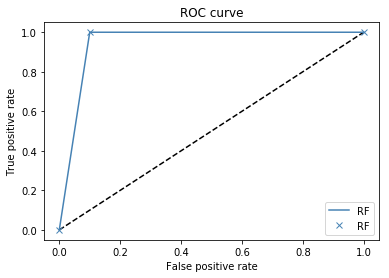

In [188]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf1, tpr_rf1, '-', color='SteelBlue', label='RF')
plt.plot(fpr_rf1, tpr_rf1, 'x', color='SteelBlue', label='RF')
#plt.plot(fpr_gdb, tpr_gdb, '-', color='IndianRed',label='GBT')
#plt.plot(fpr_gdb, tpr_gdb, 'x', color='IndianRed',label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc=4)
plt.show()

Figure 14: ROC curve to visualize the diagnostic ability of the model. As described above, this model performs better than the restricted model above. All in all, this different combination of features may help us predict SAT score better than the previous model. 

**11.3 discuss the importance of each feature in the model**

In [189]:
rf1.feature_importances_

array([ 0.13538262,  0.18292075,  0.1527995 ,  0.2175835 ,  0.16078168,
        0.15053195])

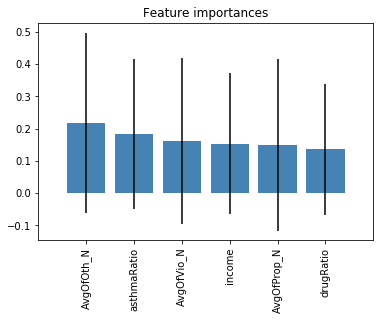

In [190]:
labels1 = ['drugRatio', 'asthmaRatio', 'income',
            'AvgOfOth_N', 'AvgOfVio_N', 'AvgOfProp_N']
featureImportancePlot(rf1, labels1)

Figure 15: Graph showing the importance of each feature in the current model. Average of Other Crime and asthma ratio are the most important features, but this graph tells us that all of the features are important. Or, put another way, perhaps none of them are really important! More discussion below.

**CONCLUSION** 
- In the end, I'm not sure we've made significant strides in detecting the influence of these various features on performance. Our small sample size certainly does not help us, nor does the missing data from the munging of various datasets.
- I think there are many issues with the features we used, most significantly the average crime features. Since these measures are aggregates of similar building populations, the spatial element of crime (which was not explored at all, really) is diminished. Further, SAT score may be a poor proxy for performance. 
- The high covariance amoung our variables was an additional problem. While we took some steps to remove redundant variables (SAT math score), we likely could have used only one or two of the crime measures in our entire analysis. 
- Finally, random forest does not appear to be a good diagnostic with such a small sample size, making the train/test samples even smaller.